<a name="top"></a>

<!---
For ToC, two helpful links:
1. https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook
2. https://stackoverflow.com/questions/5319754/cross-reference-named-anchor-in-markdown/7335259#7335259
-->

## ToC:
* [Import Packages](#import)
* [Connect to Mongo](#mongo)


* [Initialize Dataframes](#initialize)
    * initializing T & K
* [Monitor Games](#monitor)
    * showing how long each game took
    * actually making D
    * checking which games are complete
* [Cleaning the Data](#cleaning)
    * where we save D to .csv and re-import
* [Read DF from dir](#read_from_csv)
    * read the dataframe from wherever we saved it
* [RT Glitches](#glitches)
    * some (4) games had sketchers drawing before trial start
    * some trials show viewers clicking before they saw the sketch
* [Render Images](#render)
    * commented out now because it takes forever, good for galleries


* [Analyses](#analyses) (mostly done on D)
    * [Save Out DF](#save_to_csv)
    * [Accuracy](#accuracy)
    * [Draw Time](#drawtime)
    * [Efficiency](#efficiency)


* [Inter-stroke Interval](#isi) (mostly done on T)
    * [Some New Columns](#isi-cols)
    * [Some Plots](#isi-plots)
    * [Timecourse of Strokes](#isi-timecourse)
    * [Bootstrap Variance Est.](#bootstrap)

### <a name="import"></a> Import Packages, Set up Paths ([^](#top))

In [1]:
import os, sys
import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL
import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42
from IPython.display import clear_output
import importlib
from sklearn.cluster import KMeans
import shapely
import svgwrite
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# if you want the cells to be the width of your browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/Users/alles/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/alles/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

###  <a name="mongo"></a> Connect to Mongo ([^](#top))

first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [5]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [6]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['num6_shape3']

# which iteration name(s) should we use?
iterationNames = ['regularity1'] # possibilities: 'sandbox1', 'pilot1', 'sandbox2', 'sandbox3', 'pilot3'
iterationName = 'regularity1'
# this has previously been run1, then sandbox3, but switched to sandbox 3 for testing the url recording function

w = coll.find({'iterationName':iterationName, 'eventType':'survey'})
W = pd.DataFrame(w)


### <a name="initialize"></a> Initialize dataframes ([^](#top))

In [173]:
## fetch records that match our list of iterationNames
print('Currently trying to generate clickedObj group dataframe...')
k = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'clickedObj'})
## create (raw, unfiltered) group dataframe containing all clickedObj 
## data from iterationNames of interest
K = pd.DataFrame(list(k))
K = K.astype({'time': 'int'})
print('Finished generating clickedObj group dataframe.')

## now make group dataframe for stroke data
print('Currently trying to generate stroke group dataframe...')
t = coll.find({'iterationName': {'$in': iterationNames}, 'eventType':'stroke'})
T = pd.DataFrame(list(t))
T['cardinality'] = T.intendedName.str.split('_',expand=True)[1]
T = T.astype({'time': 'int',
              'startStrokeTime':'int',
              'endStrokeTime':'int',
              'currStrokeNum':'int',
              'cardinality':'int'})
print('Finished generating stroke group dataframe.')

## get list of valid game IDs (i.e, subject number)
from collections import Counter
game_dict = Counter(K['gameid']) ## get dictionary mapping gameIDs to number of sketches 
complete_gameids = [k for (k,v) in game_dict.items() if v==36] ## get gameids that contributed exactly the right number of sketches

## subset stroke/sketch dataframes by being complete AND also exclude practice
subset = True
if (subset and T['gameid'].nunique()!=len(complete_gameids)):
    T = T[(T['gameid'].isin(complete_gameids))].reset_index(drop=True)
    K = K[(K['gameid'].isin(complete_gameids))].reset_index(drop=True)
    
print('We have {} unique stroke records in all {} of our complete games.'.format(T.shape[0],len(complete_gameids)))
print('We have {} unique sketch records in all {} of our complete games.'.format(K.shape[0],len(complete_gameids)))

# save out to csv
T.to_csv(os.path.join(csv_dir,'iternum2_stroke_data.csv'),index=False)
K.to_csv(os.path.join(csv_dir,'iternum2_sketch_data.csv'),index=False)
print('Successfully saved out our stroke/sketch data CSVs to {}.'.format(csv_dir))

# changing the target url because I want it in the sketch metadata, but '/' gets read as file path, so just take suffix
for i in K.index:
    K['targ_s_url'][i] = K['targ_s_url'][i].split('/')[-1]



Currently trying to generate clickedObj group dataframe...
Finished generating clickedObj group dataframe.
Currently trying to generate stroke group dataframe...
Finished generating stroke group dataframe.
We have 23869 unique stroke records in all 100 of our complete games.
We have 3600 unique sketch records in all 100 of our complete games.
Successfully saved out our stroke/sketch data CSVs to /Users/alles/repos/iterated_number/results/csv.


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### <a name="monitor"></a> Monitor Games ([^](#top))

In [24]:
# # look at the time every game took from start to finish
# gamelist = list(coll.find({'iterationName':'regularity1'}).distinct("gameid"))
# gameDurations = []
# completeGameDurations = []

# for i,game in enumerate(gamelist):
#     print("Doing game #{} of {}".format(i+1,len(gamelist)))
#     clear_output(wait=True)
#     trials = list(coll.find({"gameid":game,'eventType':'clickedObj'}).distinct('trialNum'))
#     if len(trials) != 0:
#         trial1 = min(trials)
#         trialN = max(trials)
#         startTime = coll.find({"gameid":game,'eventType':'clickedObj','trialNum':trial1}).distinct('trialStartTime')[0]    
#         endTime = coll.find({"gameid":game,'eventType':'clickedObj','trialNum':trialN}).distinct('confirmTime')[0]
#         timeTaken = endTime - startTime
#         gameDuration = (timeTaken / 1000) / 60
#         gameDurations.append(gameDuration)
#     if len(trials) == 36:
#         trial1 = min(trials)
#         trialN = max(trials)
#         startTime = coll.find({"gameid":game,'eventType':'clickedObj','trialNum':trial1}).distinct('trialStartTime')[0]    
#         endTime = coll.find({"gameid":game,'eventType':'clickedObj','trialNum':trialN}).distinct('confirmTime')[0]
#         timeTaken = endTime - startTime
#         gameDuration = (timeTaken / 1000) / 60
#         completeGameDurations.append(gameDuration)

# # plot it for all games
# meanMinutes = np.round(np.mean(gameDurations),2)
# stdMinutes = np.round(np.std(gameDurations),2)
# lenMinutes = len(gameDurations)

# plt.figure()
# plt.hist(gameDurations,bins=30)
# plt.title("Task Times (all games; minutes)")

# print("Mean: {} minutes. \nSTD: {} minutes. \nGames: {}".format(meanMinutes,stdMinutes,lenMinutes))
# print("EV: ${} ± {}".format(np.round(14*(meanMinutes/60),2),np.round(14*(stdMinutes/60),2)))

# # now just plot it for complete games
# meanMinutes = np.round(np.mean(completeGameDurations),2)
# stdMinutes = np.round(np.std(completeGameDurations),2)
# lenMinutes = len(completeGameDurations)

# plt.figure()
# plt.hist(completeGameDurations,bins=30)
# plt.title("Task Completion Times (minutes)")

# print("Mean: {} minutes. \nSTD: {} minutes. \nComplte Games: {}".format(meanMinutes,stdMinutes,lenMinutes))
# print("EV: ${} ± {}".format(np.round(14*(meanMinutes/60),2),np.round(14*(stdMinutes/60),2)))


In [172]:
# Uncomment this to make the dataframe
# Commented because it takes forever and we don't want to accidentally run it

print('Now crunching some numbers and adding more useful columns to the raw dataframe...')
D = utils.generate_dataframe(coll, complete_gameids, iterationName, csv_dir)
print('Done processing group dataframe with lots of handy additional columns!')

# Turning things that can be numeric into numeric things
D = D.astype({'trialNum': 'float',
              'cardinality': 'float',
              'drawDuration': 'float',
              'outcome': 'float',
              'numStrokes': 'float',
              'meanPixelIntensity': 'float',
              'numCurvesPerSketch': 'float',
              'numCurvesPerStroke': 'float',
              'D1_Car': 'float',
              'D2_Car': 'float',
              'D3_Car': 'float'})

## some additional postprocessing: add arc length information to the group dataframe 
try:
    from bezier import curve
    from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path
    D = utils.GetArcLenData(D)
except:
    print('Something went wrong with adding arc length info to the dataframe, sorry!')
    pass

# Keep track of which quarter of the experiment the trial happened in
D['block'] = np.ceil(D['trialNum']/6)
D = D.astype({'block': 'float'})
D['cardinality'] = D['cardinality'] + 1 #cardinalities are 0-indexed, which is ugly

D_backup = D #we are going to exclude data from D, so might as well back it up into another variable too

Something went wrong with adding arc length info to the dataframe, sorry!


In [3]:
# look at accuracy by game
D.groupby('gameID')['outcome'].mean().hist(bins=50)
plt.title("Accuracy for All Games")

D.groupby('Regularity')['outcome'].mean()

NameError: name 'D' is not defined

#### <a name="isi-cols"></a> Make some new columns in the sketcher (T) and viewer (K) DFs ([^](#top))

In [197]:

# define stroke reaction time; if it's the first stroke
T['sRT'] = T['startStrokeTime'] -  T['trialStartTime']
T['strokeDur'] = T['endStrokeTime'] -  T['startStrokeTime']

# make some new columns for viewer reaction time
K['vRT'] = K['clickedTime'] - K['submitTime'] # viewer reaction time
K['vDT'] = K['confirmTime'] - K['clickedTime'] # viewer decision time

# wanted to store how many strokes the sketch took on every stroke entry, but two problems:
# 1: we don't need this info
# 2: the operation to do this somehow reduced the length of T from 23868 to 23357. No idea why. Let's not groupby + merge    
# # how to merge grouped PD DF to original (?):
# # https://stackoverflow.com/questions/24980437/pandas-groupby-and-then-merge-on-original-table     
# blah = T.groupby(['gameid','trialNum'])[['currStrokeNum']].max()[['currStrokeNum']].reset_index().rename(columns={'currStrokeNum':'maxStroke'})
# if 'maxStroke' not in T.columns:
#     T = T.merge(blah,on=['gameid','trialNum'])

T['firstStroke'] = T['currStrokeNum'] == 1
blah = T['endStrokeTime'].shift(1) # the ending time of last stroke (NOT good for stroke #1 of sketch) 
blah[0] = 0 # just replace the first one, which is otherwise going to be a NaN that messes things up
T['prevEndTime'] = blah
T['isi'] = np.nan  # 'inter-stroke interval'

# now do the same with startStrokeTime
blah = T['startStrokeTime'].shift(1) # the ending time of last stroke (NOT good for stroke #1 of sketch) 
blah[0] = 0 # just replace the first one, which is otherwise going to be a NaN that messes things up
T['prevStartTime'] = blah

T['sts'] = np.nan  # 'start-to-start' of the stroke

# now assign the inter-stroke interval, ignoring 'prevEndTime' if on the first stroke
T['isi'] = T['firstStroke']*T['sRT'] + (1-T['firstStroke'])*(T['startStrokeTime'] - T['prevEndTime'])
T['sts'] = T['firstStroke']*T['sRT'] + (1-T['firstStroke'])*(T['startStrokeTime'] - T['prevStartTime'])


T['timeDiff'] = T['isi'] - T['strokeDur']

T['animal'] = T['targ_s_url'].apply(lambda x: x.split('_')[1])

###  <a name="cleaning"></a> Cleaning the Data ([^](#top))
#### This code was *after* image rendering to sort out the duds. Now it has been moved to *before* image rendering so that we only generate the images that we want to analyze in the NN

In [209]:
# Get the data out onto a CSV so we can do some analysis in R

# First clean it up by removing games that we have to exclude. Get dud games manually:
dud_games = ['9852-69340911-592c-4469-91a1-7bb58ae4fc40',   # wrote Arabic numbers
             '1532-126aa9fb-b331-4b1d-b3bd-14b8d397fe69',   # wrote Arabic numbers
             '8455-59b6d31b-21c8-4534-aa89-7d96be21275c',   # wrote Arabic numbers
             '0379-88447599-199d-4930-86eb-45a5bcfcd0e9',   # wrote Arabic numbers
             '5057-8314d547-2119-484b-8ed8-292ba0819395',   # wrote Arabic numbers
             '6814-d2c17a13-a0f0-459c-b10e-a11fb6b6046d',   # wrote Arabic numbers
             '2534-036a9276-5839-475f-a859-75e96c529c74',   # weird sketcher RT glitch
             '2590-5c03c7de-2316-42ef-917e-75dcf4ea3d70',   # weird sketcher RT glitch
             '7919-3b01f5d5-343e-4dd4-a3f3-da5504807930',   # weird sketcher RT glitch
             '9229-771b97f0-185b-4ecc-86a0-dec48211501c'
            ]   # weird sketcher RT glitch

# now remove them from both D and K
for dud in dud_games:
    D = D[D.gameID != dud]
    K = K[K.gameid != dud]
    T = T[T.gameid != dud]

# the names of the games we want to keep:
kosher_games = [game for game in complete_gameids if game not in dud_games]

# remove games where accuracy was lower than our preregistered criteria (standard deviation and absolute 50% acc)
Dall = D

Dlow_acc = D[D['low_acc'] == True]
Dfailed = D[D['failed'] == True]
Dbad = pd.concat([Dlow_acc, Dfailed])
bad_games = Dbad['gameID'].unique()

Dgood = D[D['low_acc'] == False]
Dgood = Dgood[Dgood['failed'] == False]
good_games = Dgood['gameID'].unique()
D = Dgood

for bad in bad_games:
    K = K[K.gameid != bad]
    T = T[T.gameid != bad]
    
print("Done exclusions. Now to anonymize games...")

# # NOW anonymize the game IDs so they're not so annoying to work with, once we've excluded from all DFs
# D[['gameID']] = D[['gameID']].applymap(lambda x: "G" + str(int(np.where(D.gameID.unique() == x)[0])+1))
# K[['gameid']] = K[['gameid']].applymap(lambda x: "G" + str(int(np.where(K.gameid.unique() == x)[0])+1))
# T[['gameid']] = T[['gameid']].applymap(lambda x: "G" + str(int(np.where(T.gameid.unique() == x)[0])+1))

print("Done anonymization. Now export D as csv...")



# generate a column in D showing the relationship between cardinality and numstrokes (use of 1-to-1)
D['putative_1to1'] = D['numStrokes'] >= D['cardinality']
D['strategy'] = D['putative_1to1'].replace(False, 'other').replace(True, '1-to-1') 
# D['strategy'] = D['putative_1to1']
# look at the ratio of numStrokes to cardinality
D['strokeRatio'] = D['numStrokes'] / D['cardinality']

# uncomment the following when running the whole thing again:
# now let's add in to D the vRT column from the clicked-object dataframe
toAdd = K[['gameid','trialNum','vRT']].rename(columns={"gameid": "gameID"})
D = D.merge(toAdd, on=['gameID','trialNum'])  
D = D.rename(columns={"vRT_y": "vRT"})#.drop(columns=['vRT_x'])


# now let's add in to D the vRT column from 
toAdd = K[['gameid','trialNum','vRT']].rename(columns={"gameid": "gameID"})
D = D.merge(toAdd, on=['gameID','trialNum'])


D.to_csv(os.path.join(csv_dir,'iternum_data2_incl.csv'))



# Export the csv. This is what the R script will look at
D.to_csv(os.path.join(csv_dir,'iternum_group_data_{}.csv'.format(iterationName)))
T.to_csv(os.path.join(csv_dir,'iternum2_stroke_data_{}.csv'.format(iterationName)))
K.to_csv(os.path.join(csv_dir,'iternum2_sketch_data_{}.csv'.format(iterationName)))

print("Done")

Done exclusions. Now to anonymize games...
Done anonymization. Now export D as csv...
Done


### <a name="read_from_csv"></a> Now read D up from the folder ([^](#top))

In [7]:
# re-read it from the csv
D = pd.read_csv(os.path.join(csv_dir,'iternum_group_data_{}.csv'.format(iterationName)))
T = pd.read_csv(os.path.join(csv_dir,'iternum2_stroke_data.csv')) # had keyword "index=False"; not sure why
K = pd.read_csv(os.path.join(csv_dir,'iternum2_sketch_data.csv')) # had keyword "index=False"; not sure why

print("How many games are there in each condition?")

D.groupby('Regularity')['gameID'].nunique()

How many games are there in each condition?


Regularity
random     27
regular    29
Name: gameID, dtype: int64

In [10]:
D.groupby('Regularity')['gameID'].nunique()
K.groupby('regularity')['gameid'].nunique()

def get_confint(df):
    """Takes a df already with columns ['Factors','mean','count','std'] """
    new_df = df
    ci95_hi = []
    ci95_lo = []
    for i in new_df.index:
        m, c, s = new_df.loc[i]
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    new_df['ci95_hi'] = ci95_hi
    new_df['ci95_lo'] = ci95_lo
    new_df['yerr'] = new_df['ci95_hi'] - new_df['ci95_lo']
    return new_df


D['one2one'] = D['strokeRatio'] == 1
D['compressed'] = D['strokeRatio'] < 1
D['compressed'].mean()
D['allgames'] = 1


get_confint(pd.DataFrame(D.groupby(['Regularity']).agg(['mean', 'count', 'std']))['one2one'])
# get_confint(pd.DataFrame(D.groupby(['allgames']).agg(['mean', 'count', 'std']))['compressed'])


,mean,count,std,ci95_hi,ci95_lo,yerr
Regularity,,,,,,
random,0.158436,972,0.365338,0.181404,0.135469,0.045935
regular,0.156130,1044,0.363153,0.178159,0.134101,0.044058


array(['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11',
       'G12', 'G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20',
       'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29',
       'G30', 'G31', 'G32', 'G33', 'G34', 'G35', 'G36', 'G37', 'G38',
       'G39', 'G40', 'G41', 'G42', 'G43', 'G44', 'G45', 'G46', 'G47',
       'G48', 'G49', 'G50', 'G51', 'G52', 'G53', 'G54', 'G55', 'G56',
       'G57', 'G58', 'G59'], dtype=object)

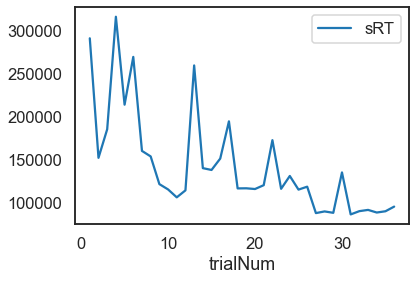

In [46]:
T.groupby(['trialNum'])[['sRT']].mean().plot()

# set(K['gameid'].unique()).difference(set(D['gameID'].unique()))
D['gameID'].unique()

### <a name="save_to_csv"></a> Now save D out to the folder ([^](#top))

### <a name="glitches"></a> Sort out RT Glitches ([^](#top))

Average acc of trials with 'negative' viewer RT: 0.28865979381443296
Avg acc of all viewer trials 0.6541666666666667

Proportion of strokes with negative 'RT'? 0.01612446603201882
Proportion of clicks with negative RT? 0.053888888888888875


0.000000    71
0.083333     7
0.027778     5
0.166667     4
0.333333     2
0.194444     2
0.055556     2
0.416667     1
0.583333     1
0.472222     1
0.361111     1
0.638889     1
0.250000     1
0.111111     1
Name: vRT, dtype: int64

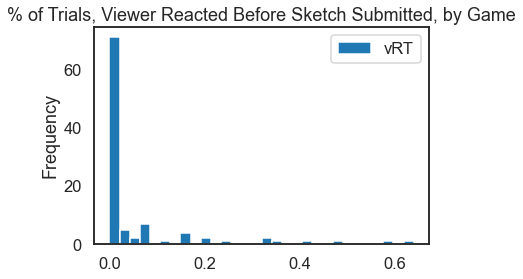

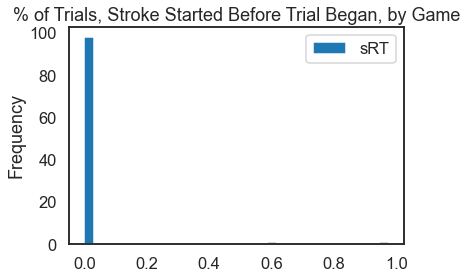

In [21]:
# coll.find({'iterationName':iterationName}).distinct("eventType")
T.groupby(['gameid','trialNum'])[['currStrokeNum']].min()
# T['strokeDuration'] = T['endStrokeTime'] - T['startStrokeTime']
# T.columns#['strokeDuration'].plot.hist(bins=30)

# K.groupby(['gameid','trialNum'])[['submitTime','clickedTime','confirmTime']].mean()


# K['vDT'].plot.hist(bins=400,xlim=(K['vDT'].mean()-K['vDT'].std(),
#                                  K['vDT'].mean()+K['vDT'].std()))

K.groupby('gameid')[['vRT']].agg(lambda x: np.mean(x < 0)).plot.hist(bins=30,
                                                                     title="% of Trials, Viewer Reacted Before Sketch Submitted, by Game",
                                                                     xlabel="% of Trials within Game")

T.groupby('gameid')[['sRT']].agg(lambda x: np.mean(x < 0)).plot.hist(bins=30,
                                                                     title="% of Trials, Stroke Started Before Trial Began, by Game",
                                                                     xlabel="% of Trials within Game")

print("Average acc of trials with 'negative' viewer RT: {}\nAvg acc of all viewer trials".format(
    K[K['vRT'] < 0][['trialNum','regularity','intendedName','correct','clickedName']].correct.mean()),
      K.correct.mean())

print()
print("Proportion of strokes with negative 'RT'? {}".format(T.groupby('gameid')[['sRT']].agg(lambda x: np.mean(x < 0)).mean()[0]))    
print("Proportion of clicks with negative RT? {}".format(K.groupby('gameid')[['vRT']].agg(lambda x: np.mean(x < 0)).mean()[0]))    


T.groupby('gameid')[['sRT']].agg(lambda x: np.mean(x < 0)).sRT.value_counts()
K.groupby('gameid')[['vRT']].agg(lambda x: np.mean(x < 0)).vRT.value_counts()

In [ ]:
K[K['vRT'] < 10000].vRT.plot.hist(bins=100,title="Viewer Response Latency")
plt.axvline(x=0, color='r', linestyle='dashed',linewidth=1) 
# why is this happening? Look at game.client.js, line 611
# the listener for clicked object is being set up with each new trial,
# NOT with the submission from the viewer
# Proposed explanation: viewers are sometimes clicking too early, and we're recording that
# accuracy data of these trials is around chance, supporting this
# furthermore, K['clickedTime'] - K['trialStartTime'] is always +ve

# perhaps write a note in the methods section
# ("due to a glitch, viewers in 5% of trials made their response before seeing the sketcher's image")

plt.figure()
T[T['sRT'] < 20000].sRT.plot.hist(bins=100,title="Stroke Initiation Latency")
plt.axvline(x=0, color='r', linestyle='dashed',linewidth=1) 
# why is this happening?
# below

# again, we can do the exploratory analyses we want to , and simply point out that there was a glitch
# which may have only been an issue for those four games
# 

plt.figure()
T[T['sRT'] < 0].hist(column='sRT',by='gameid',bins=100,figsize=(12,12))
# plt.axvline(x=T[T['sRT'] < 0].sRT.mean(), color='r', linestyle='dashed',linewidth=2) 


In [ ]:
# # let's look at the distribution of stroke start time latencies for every game
# gamesByMeansRT = T.groupby('gameid')[['sRT']].mean().sort_values(by='sRT').index

# f , axs = plt.subplots(nrows = len(gamesByMeansRT), ncols = 1,figsize=(16,4*len(gamesByMeansRT)),sharex=True)

# for n,game in enumerate(gamesByMeansRT):
#     T[T['gameid'] == game].sRT.hist(bins=100,
#                                     ax=axs[n])
#     axs[n].set_xlim([-20000,60000])
#     axs[n].axvline(x=T[T['gameid'] == game].sRT.mean(), color='r', linestyle='dashed',linewidth=1)
#     axs[n].axvline(x=0, color='g', linestyle='dashed',linewidth=1)


In [ ]:
# T[T['sRT'] < 0].gameid.unique()

# T['strokeDur'].min()

# (K['clickedTime'] - K['trialStartTime']).min()

# (T['startStrokeTime'].value_counts() > 1).sum()

# # T.groupby(['startStrokeTime','gameid'])[['startStrokeTime']].count()


# # based on the following, we can infer that startStrokeTime never 'held over' from previous trial
# # this is because any two startStrokeTime values that are identical, come from different games
# # not, as we would expect, the same game but consecutive trials

# blah = dict(T['startStrokeTime'].value_counts() > 1) # how often did two entries have same startStrokeTime?
# T['doubleSStime'] = T['startStrokeTime'].apply(lambda x: blah[x] == True) # make a column for these duplicates
# T[T['doubleSStime'] == True][['startStrokeTime','gameid']].groupby(['startStrokeTime','gameid']).count()
# # ^ see if the duplicate came from same or different games
# # they came from different games, so that means the measure IS being updated every round

In [ ]:
# # What distinguishes the 'time' column from other timestamp columns?

# T['regTime'] = T['time'] - T['endStrokeTime'] # the time it takes to register the end of stroke??
# # T['regTime'].plot.hist(bins=1000,xlim=(-5000000,1000000))

# T.groupby(['gameid'])[['regTime']].agg(['mean', 'count', 'var'])

# T[T['regTime'] > 0]['regTime'].plot.hist(bins=1000,xlim=[-500,2000],figsize=(12,6))

### <a name="render"></a> Rendering Images ([^](#top))

#### render out all the sketches

In [ ]:
# importlib.reload(utils)
# utils.render_images(K,data = 'pngString',
#                     metadata = ['gameid','intendedName','trialNum','game_condition','targ_s_url'],
#                     out_dir = sketch_dir,
#                     delimiter = '_', # used to be '_', but changed because want url in metadata and url has '_'
#                     savetargs = False)
# #                     NN=True) # why did I write this? Might be a version control mistake here somewhere...

#### make sketch gallery (for complete games only)

In [ ]:
# importlib.reload(utils)
# ## actually render sketch gallery for each complete game
# utils.render_sketch_gallery(complete_gameids,
#                             D,
#                             sketch_dir = sketch_dir,
#                             gallery_dir = gallery_dir,
#                             num_trials = 36,
#                             by_trialnum = True,
#                             show_correct = True,
#                             transpose=False,
#                             delimiter='_')

#### show sketch sketches next to their stimuli

In [ ]:
# for i,d in D.iterrows():
#     print("Working on row {} of {}".format(i,len(D)))
#     clear_output(wait=True)
#     trialBackground = Image.new('RGBA', (400, 200),color='white')
#     im = Image.open(BytesIO(base64.b64decode(d['png']))).resize((200,200))
#     get_stim = requests.get(d['Targ_s_Url'])
#     stim = Image.open(BytesIO(get_stim.content)).resize((200,200))
    
#     trialBackground.paste(im, (0,0))
#     trialBackground.paste(stim, (200,0))
#     trialName = d['gameID'] + '_' + str(int(d['cardinality'])) + d['category']+ '_' + 'trial' + str(int(d['trialNum']))
#     trialBackground.save(os.path.join('../sketch_stim_trials',trialName+'.png'),'PNG')
    
    
# trialBackground

#### show sketch galleries with target stimulus below

In [ ]:
# # Looking visually to see if the spatial distributions of sketcher target matches the sketches
# def show_targ_and_sketch(ID,trialnum,disp=True):
#     """
#     Just a function that plots a sketch (specified by the gameID and trial number) with its target stimulus.
#     Output of this function is the image showing both side by side.
#     """
#     game = D[D.gameID == ID]
#     trial = game[game.trialNum == trialnum]
#     stim_url = trial['Targ_s_Url'].values[0]
#     get_stim = requests.get(stim_url)
#     stim = Image.open(BytesIO(get_stim.content))
#     correct = trial['outcome'].values[0]
#     background_colour = "#1EB012" if correct == 1 else "#D31F13"
    
#     get_sketch = trial['png'].values[0]
#     sketch = Image.open(BytesIO(base64.b64decode(get_sketch)))
    
#     sketch = sketch.resize((100,100))
#     stim = stim.resize((100,100))
    
#     images = [sketch,stim]
#     widths, heights = zip(*(i.size for i in images))
#     total_width = max(widths)
#     max_height = sum(heights)
#     whole_trial = Image.new('RGBA', (total_width, max_height),color=background_colour)
#     y_offset = 0
#     for im in images:
#         whole_trial.paste(im, (0,y_offset))
#         y_offset += im.size[1] + 5
#     if disp == True:    # this is for displaying it in the jupyter GUI
#         display(whole_trial)
#     return whole_trial

# def show_targs_sketches_game(ID,save=False,by_trial=True):
#     """
#     This function takes in a gameID and shows sketches and their targets for every trial, side by side.
#     Optionally, it will save this output into a png.
#     """
#     d = D[D.gameID == ID]
#     # either make the width same as [possibly incomplete game] or hard-code it
#     numTrials = int(d['trialNum'].max())
# #     width = numTrials
#     width = 36
    
#     if by_trial == False:
#         whole_game = Image.new('RGBA', (int(width*100/2), 410),color='white') # /2 because 2 halves of the experiment
#         whole_game.putalpha(0)
#         cardinalities = np.sort(d['cardinality'].unique())
#         animals = d['category'].unique()
#         for i,c in enumerate(cardinalities):
#             for j,a in enumerate(animals):
#                 # get all the instances of this cardinality-animal combo in the game (there are 2!)
#                 trialnums = d[(d.cardinality == c) & (d.category == a)]['trialNum'].unique()
#                 for k,t in enumerate(trialnums):
#                     trial = show_targ_and_sketch(ID,int(t),disp=False)
#                     whole_game.paste(trial,(j*100+i*300,k*205)) # k is binary - either 0 or 205
# #                     print(i,j,k)
# #                     clear_output(wait=True)
    
#     if by_trial == True:
#         whole_game = Image.new('RGBA', (width*100, 205),color='white')
#         whole_game.putalpha(0)
#         for trial_num in np.arange(1,numTrials+1):
#             trial = show_targ_and_sketch(ID,trial_num,disp=False)
#             whole_game.paste(trial,(trial_num*100-100,0))
        
#     if save == True:
#         condition = D[D.gameID == ID]['Game_Condition'].values[0]
#         regularity = D[D.gameID == ID]['Regularity'].values[0]
#         fname = str(regularity) + '_' + ID + "_ss"
        
#         out_dir = '../sketches_stims'
#         # create the out_dir if it does not already exist
#         if not os.path.exists(out_dir): 
#             os.makedirs(out_dir)
            
#         # now save the image out to that directory
#         if not os.path.exists(os.path.join(out_dir,fname+'.png')):
# #             print('Rendering…', fname + '.png') 
#             whole_game.save(os.path.join(out_dir,fname+'.png'),'PNG')
            
#     return whole_game

# for i,game_id in enumerate(good_games):
#     print("Now generating sketch + stim display for {} ({} of {})".format(game_id,i+1,len(good_games)))
#     clear_output(wait=True)
#     show_targs_sketches_game(game_id,save=True,by_trial=False)

# print("Done")

In [ ]:
# # put all the new gallery images onto one canvas
# sketches_stims = '../sketches_stims'
# stim_paths = sorted([i for i in os.listdir('../sketches_stims') if i.split('/')[-1] not in ['.DS_Store','all_games.png']]) ## deborkify    

# bigcanvas = Image.new('RGBA', (36*100, 205*len(stim_paths)),color='black')

# for i,image in enumerate(stim_paths):
#     gallery = Image.open(os.path.join(sketches_stims,image))
#     bigcanvas.paste(gallery,(0,i*205))

# bigcanvas.save(os.path.join(sketches_stims,'all_games.png'),'PNG')

# <a name="analyses"></a> Analyses ([^](#top))

In [33]:
Dreg = D[D['Regularity'] == 'regular'] # colour = '#5a9acc' = blue
Dran = D[D['Regularity'] == 'random'] # colour = '#b54aae' = magenta


In [12]:
# set colours
condColours = ['#BD83C7','#7DCCF4'] # first random, then regular
stratColours = {'1-to-1':'black',
                'other':'red'}
stratColours = ['#bdbdbd','#5c5c5c'] # first 1-to-1, then other


In [215]:

# (a) qualitative sketch data
# (b) accuracy
# (c) preparatory time and sketch time
# (d) ink use distribution
# (e) all variables over time

# make a measure of efficiency
# D.groupby('gameID')['outcome'].agg(stats.zscore())
D['efficiency'] = np.nan

for gameid in D['gameID'].unique():
#     print("ACC", D[D['gameID'] == gameid]['outcome'])
#     print("DUR ",D[D['gameID'] == gameid]['drawDuration'])
    if np.nanvar(D[D['gameID'] == gameid]['outcome']) != 0:
        zScoreAcc = stats.zscore(D[D['gameID'] == gameid]['outcome'],nan_policy='omit')
    else:
        zScoreAcc = np.zeros(36) # is this the right way to do this?
    zScoreDur = stats.zscore(D[D['gameID'] == gameid]['drawDuration'],nan_policy='omit')
    efficiency = zScoreAcc - zScoreDur
    for trialnum in D[D['gameID']==gameid]['trialNum'].unique():
        curGame = D.loc[D['gameID'] == gameid]
        ind = curGame[curGame['trialNum'] == trialnum].index[0]
        D['efficiency'][ind] = efficiency[ind] # efficiency[ind] used to be efficiency[int(trialnum-1)] (which incorrectly resets per game)
        # additionally, D.loc[:, ('efficiency', ind)] had originally been D['efficiency'][ind], which threw a warning but actually seemed to run faster

        
Dreg = D[D['Regularity'] == 'regular'] # colour = '#5a9acc' = blue
Dran = D[D['Regularity'] == 'random'] # colour = '#b54aae' = magenta


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38:

### <a name="accuracy"></a> Look at Accuracy over IVs ([^](#top))

Text(0.5, 0, '')

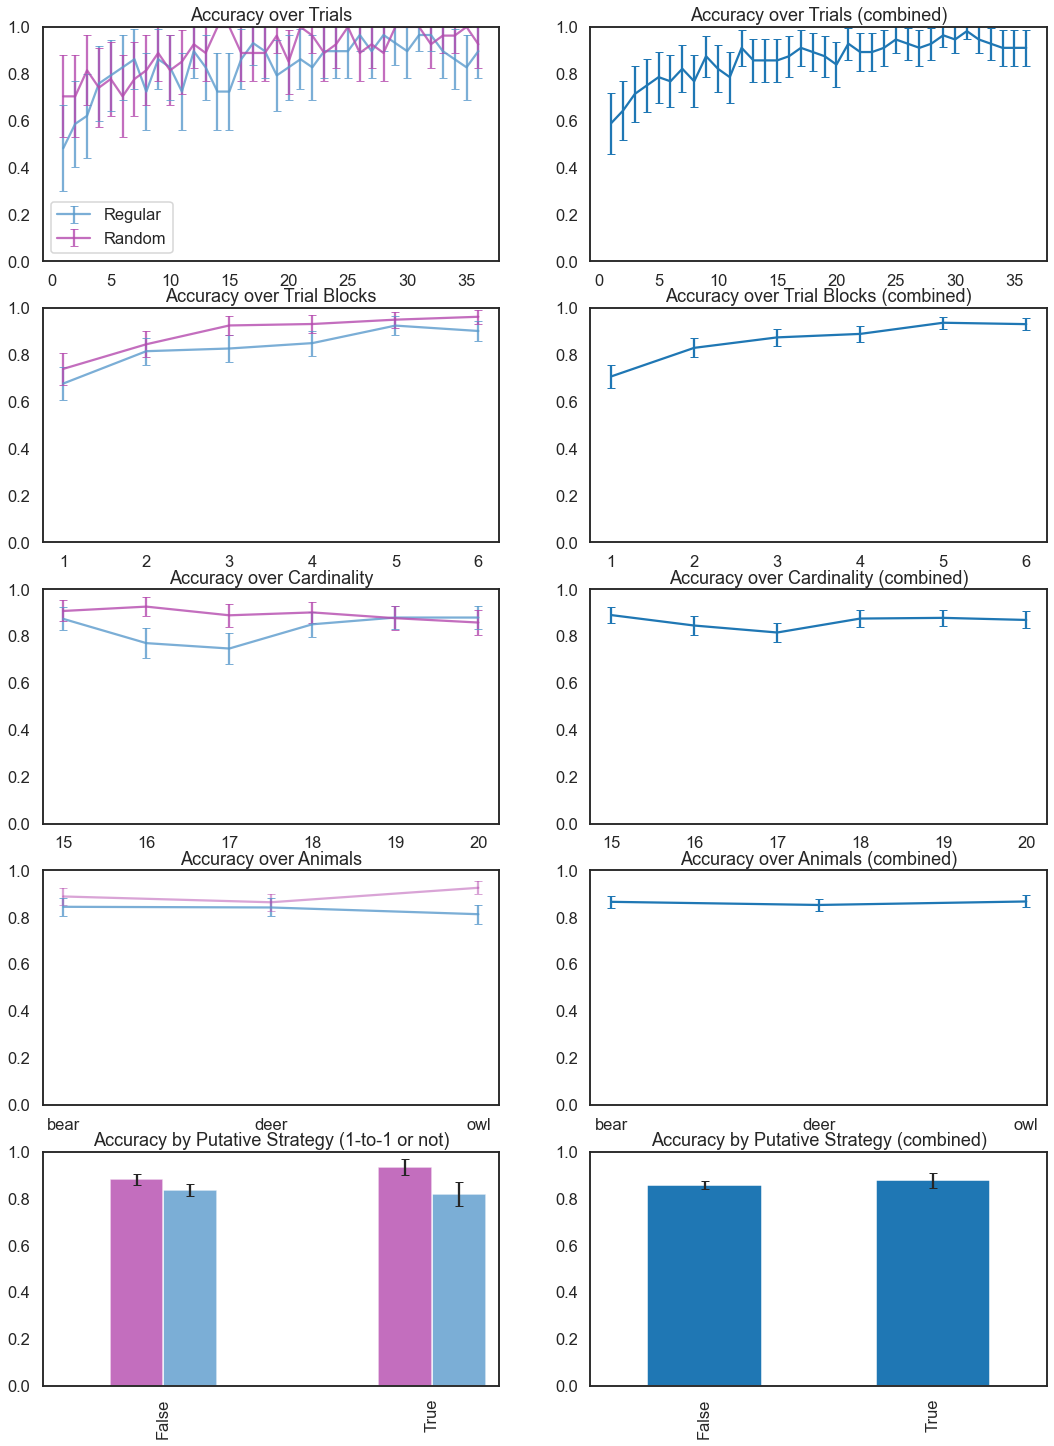

In [216]:
a = .8
c = 4

fig, ((trials1,trials2),
      (blocks1,blocks2),
      (cards1,cards2),
      (cats1,cats2),
      (strat1,strat2)) = plt.subplots(nrows=5, ncols=2,figsize=(18,25))

blah = get_confint(pd.DataFrame(Dreg.groupby(['trialNum']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['trialNum']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
trials1.set_title("Accuracy over Trials")
trials1.set_ylim(0,1)
trials1.set_xlabel("")
trials1.legend(['Regular','Random'])
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=trials2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
trials2.set_title("Accuracy over Trials (combined)")
trials2.set_ylim(0,1)
trials2.set_xlabel("")




blah = get_confint(pd.DataFrame(Dreg.groupby(['block']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['block']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
blocks1.set_title("Accuracy over Trial Blocks")
blocks1.set_ylim(0,1)
blocks1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['block']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=blocks2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
blocks2.set_title("Accuracy over Trial Blocks (combined)")
blocks2.set_ylim(0,1)
blocks2.set_xlabel("")



blah = get_confint(pd.DataFrame(Dreg.groupby(['cardinality']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['cardinality']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
cards1.set_title("Accuracy over Cardinality")
cards1.set_ylim(0,1)
cards1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cards2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cards2.set_title("Accuracy over Cardinality (combined)")
cards2.set_ylim(0,1)
cards2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['category']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['category']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=.5)
cats1.set_title("Accuracy over Animals")
cats1.set_ylim(0,1)
cats1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['category']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(ax=cats2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cats2.set_title("Accuracy over Animals (combined)")
cats2.set_ylim(0,1)
cats2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot.bar(ax=strat1,position=0,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot.bar(ax=strat1,position=1,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
strat1.set_title("Accuracy by Putative Strategy (1-to-1 or not)")
strat1.set_ylim(0,1)
strat1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot.bar(ax=strat2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
strat2.set_title("Accuracy by Putative Strategy (combined)")
strat2.set_ylim(0,1)
strat2.set_xlabel("")

,mean,count,std,ci95_hi,ci95_lo,yerr
Regularity,,,,,,
random,0.893004,972,0.309267,0.912447,0.873561,0.038885
regular,0.833333,1044,0.372857,0.855951,0.810716,0.045235


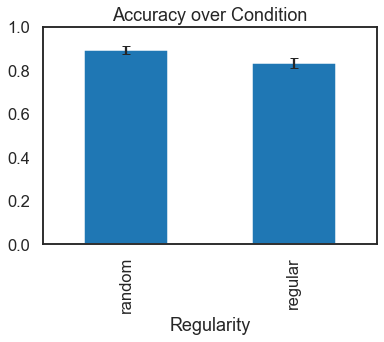

In [217]:

# plot the average accuracy over time
blah = get_confint(pd.DataFrame(D.groupby(['Regularity']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot.bar(y='mean',yerr=blah['ci95_hi'] - blah['mean'],legend=None,capsize=4)
plt.title("Accuracy over Condition")
plt.ylim(0,1)

blah


### <a name="drawtime"></a> Look at Draw Time over IVs ([^](#top))

Text(0.5, 0, '')

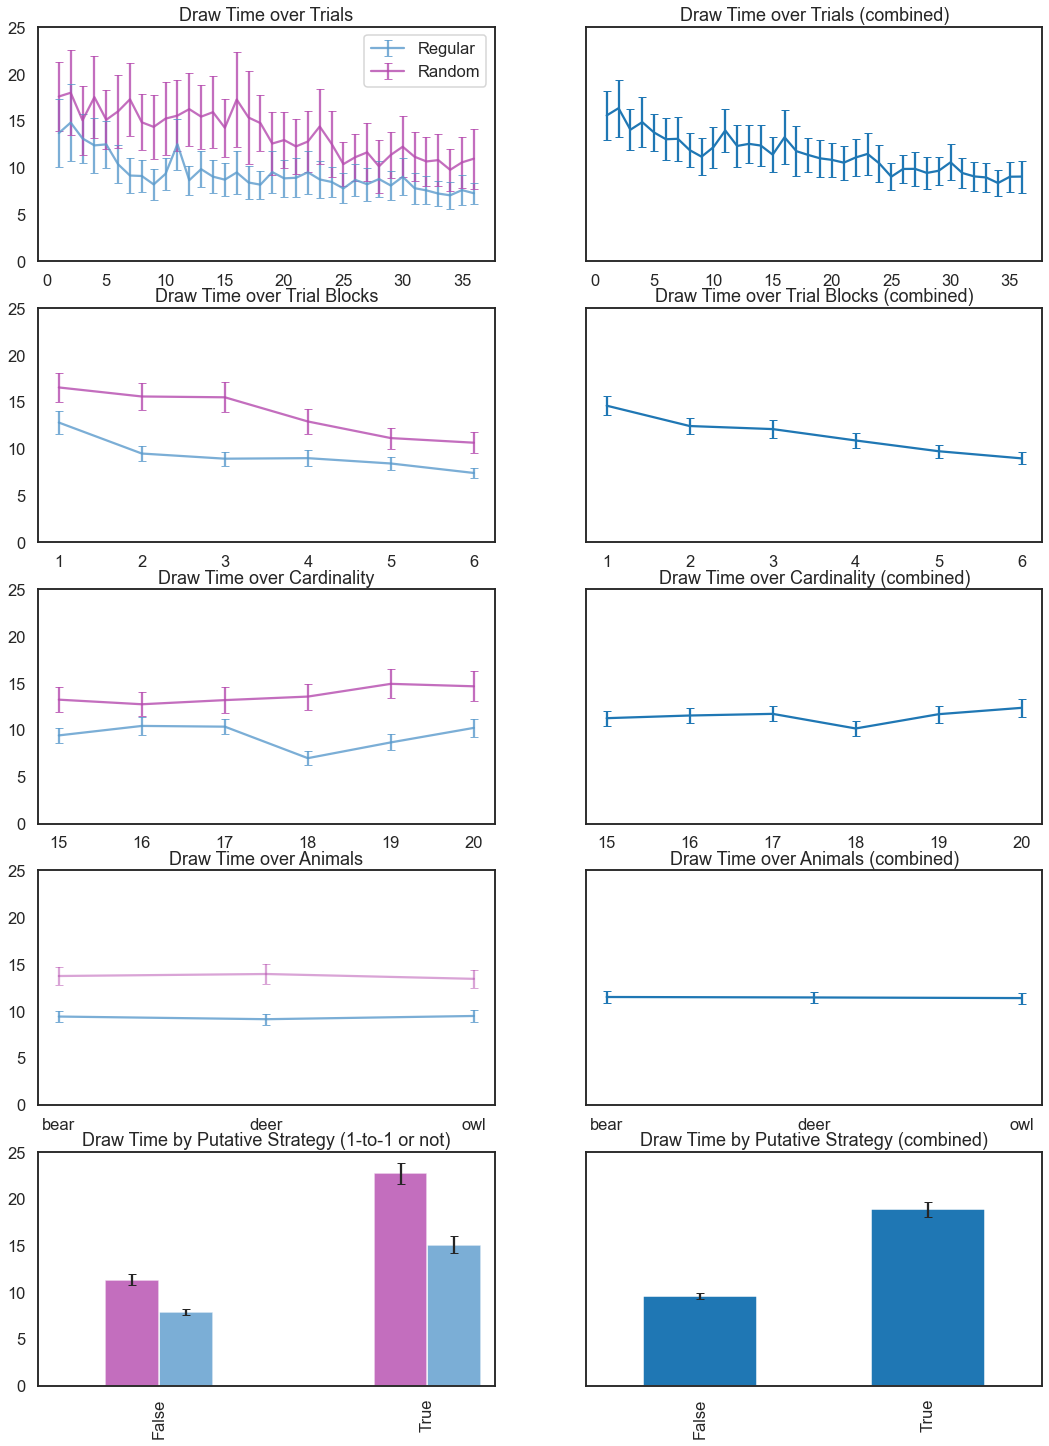

In [218]:
a = .8
c = 4

fig, ((trials1,trials2),
      (blocks1,blocks2),
      (cards1,cards2),
      (cats1,cats2),
      (strat1,strat2)) = plt.subplots(nrows=5, ncols=2,figsize=(18,25),sharey=True)

blah = get_confint(pd.DataFrame(Dreg.groupby(['trialNum']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['trialNum']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
trials1.set_title("Draw Time over Trials")
# trials1.set_ylim(0,1)
trials1.set_xlabel("")
trials1.legend(['Regular','Random'])
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=trials2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
trials2.set_title("Draw Time over Trials (combined)")
# trials2.set_ylim(0,1)
trials2.set_xlabel("")




blah = get_confint(pd.DataFrame(Dreg.groupby(['block']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['block']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
blocks1.set_title("Draw Time over Trial Blocks")
# blocks1.set_ylim(0,1)
blocks1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['block']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=blocks2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
blocks2.set_title("Draw Time over Trial Blocks (combined)")
# blocks2.set_ylim(0,1)
blocks2.set_xlabel("")



blah = get_confint(pd.DataFrame(Dreg.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
cards1.set_title("Draw Time over Cardinality")
# cards1.set_ylim(0,1)
cards1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cards2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cards2.set_title("Draw Time over Cardinality (combined)")
# cards2.set_ylim(0,1)
cards2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['category']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['category']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=.5)
cats1.set_title("Draw Time over Animals")
# cats1.set_ylim(0,1)
cats1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['category']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cats2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cats2.set_title("Draw Time over Animals (combined)")
# cats2.set_ylim(0,1)
cats2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot.bar(ax=strat1,position=0,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot.bar(ax=strat1,position=1,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
strat1.set_title("Draw Time by Putative Strategy (1-to-1 or not)")
# strat1.set_ylim(0,1)
strat1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot.bar(ax=strat2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
strat2.set_title("Draw Time by Putative Strategy (combined)")
# strat2.set_ylim(0,1)
strat2.set_xlabel("")

Text(0.5, 1.0, 'Draw Time by Condition')

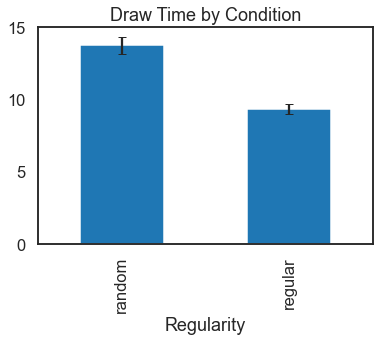

In [219]:

blah = get_confint(D.groupby(['Regularity']).agg(['mean', 'count', 'std'])['drawDuration'])
blah.plot.bar(y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
plt.title("Draw Time by Condition")

### <a name="efficiency"></a> Look at Efficiency over IVs ([^](#top))

Text(0.5, 0, '')

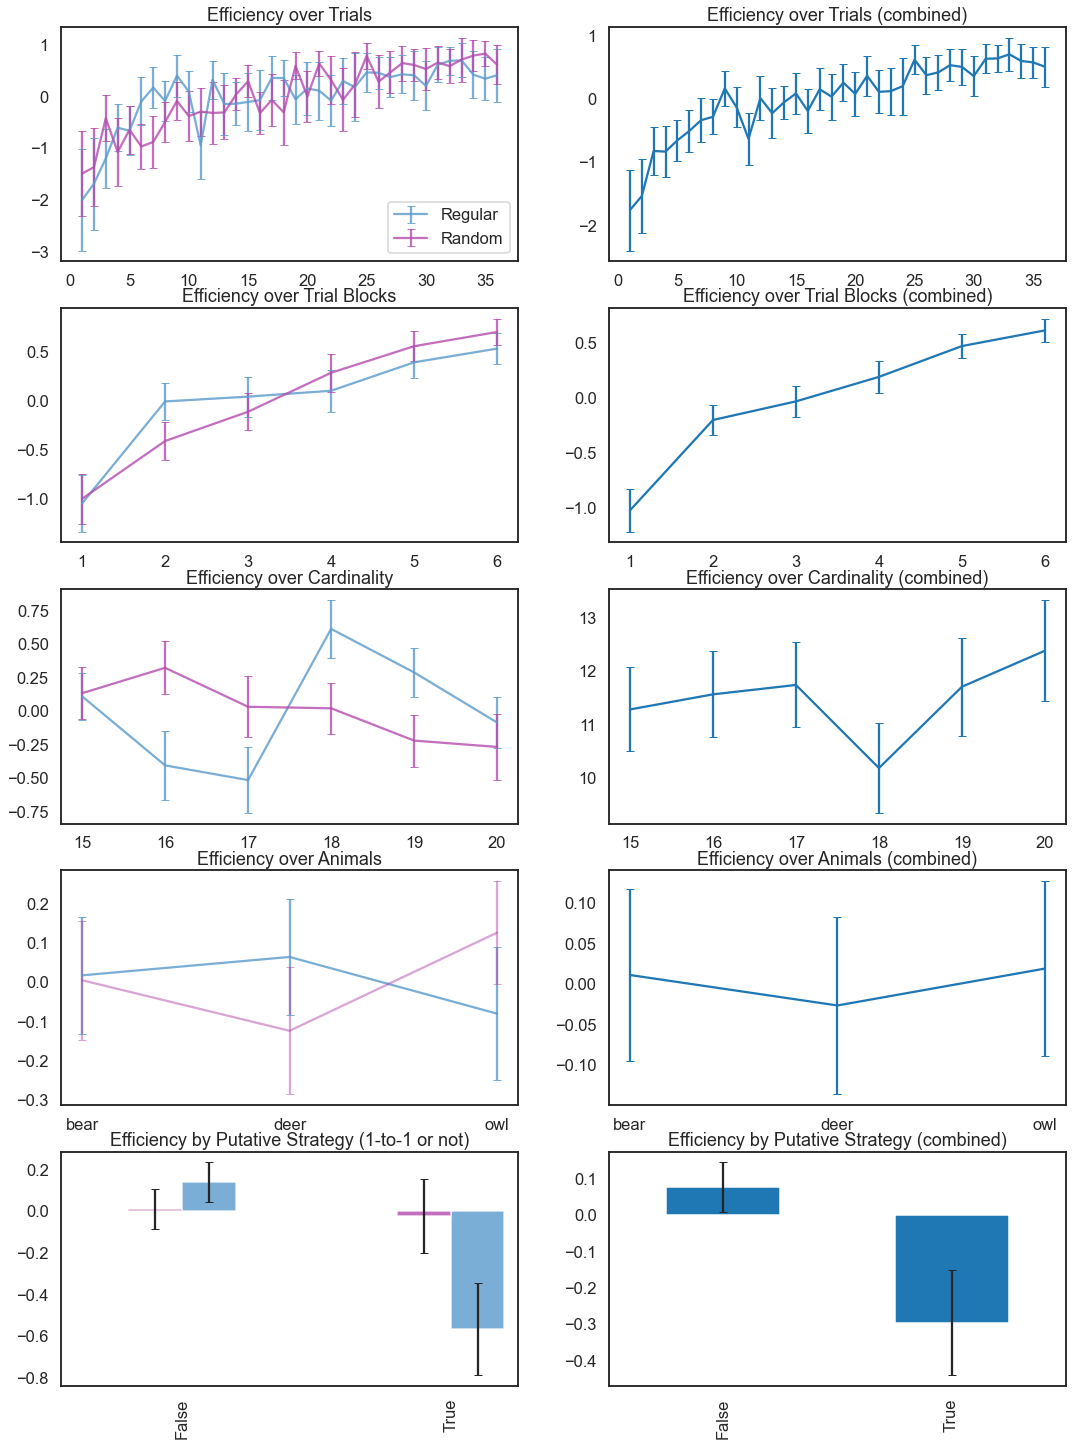

In [220]:
a = .8
c = 4

fig, ((trials1,trials2),
      (blocks1,blocks2),
      (cards1,cards2),
      (cats1,cats2),
      (strat1,strat2)) = plt.subplots(nrows=5, ncols=2,figsize=(18,25),sharey=False)

blah = get_confint(pd.DataFrame(Dreg.groupby(['trialNum']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['trialNum']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
trials1.set_title("Efficiency over Trials")
# trials1.set_ylim(0,1)
trials1.set_xlabel("")
trials1.legend(['Regular','Random'])
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=trials2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
trials2.set_title("Efficiency over Trials (combined)")
# trials2.set_ylim(0,1)
trials2.set_xlabel("")




blah = get_confint(pd.DataFrame(Dreg.groupby(['block']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['block']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=blocks1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
blocks1.set_title("Efficiency over Trial Blocks")
# blocks1.set_ylim(0,1)
blocks1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['block']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=blocks2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
blocks2.set_title("Efficiency over Trial Blocks (combined)")
# blocks2.set_ylim(0,1)
blocks2.set_xlabel("")



blah = get_confint(pd.DataFrame(Dreg.groupby(['cardinality']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['cardinality']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=cards1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
cards1.set_title("Efficiency over Cardinality")
# cards1.set_ylim(0,1)
cards1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(ax=cards2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cards2.set_title("Efficiency over Cardinality (combined)")
# cards2.set_ylim(0,1)
cards2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['category']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['category']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=cats1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=.5)
cats1.set_title("Efficiency over Animals")
# cats1.set_ylim(0,1)
cats1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['category']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot(ax=cats2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
cats2.set_title("Efficiency over Animals (combined)")
# cats2.set_ylim(0,1)
cats2.set_xlabel("")


blah = get_confint(pd.DataFrame(Dreg.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot.bar(ax=strat1,position=0,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)
blah = get_confint(pd.DataFrame(Dran.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot.bar(ax=strat1,position=1,width=.2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#b54aae',alpha=a)
strat1.set_title("Efficiency by Putative Strategy (1-to-1 or not)")
# strat1.set_ylim(0,1)
strat1.set_xlabel("")
blah = get_confint(pd.DataFrame(D.groupby(['putative_1to1']).agg(['mean', 'count', 'std']))['efficiency'])
blah.plot.bar(ax=strat2, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None)
strat2.set_title("Efficiency by Putative Strategy (combined)")
# strat2.set_ylim(0,1)
strat2.set_xlabel("")

# Chisq on acc over game condition and strategy

In [ ]:

from scipy.stats import chisquare
chisquare([1 , 2])
chisquare([10 , 20])

<AxesSubplot:xlabel='Regularity'>

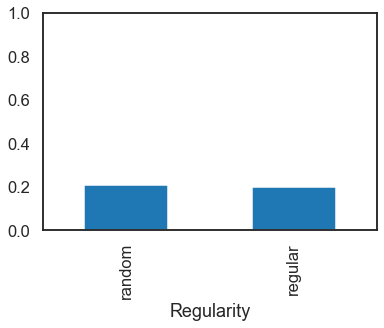

In [221]:
fig, ax1 = plt.subplots()

D.groupby(['Regularity'])['putative_1to1'].mean().plot(kind='bar', stacked=True, ylim=(0,1))


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Stroke Ratio by Condition')

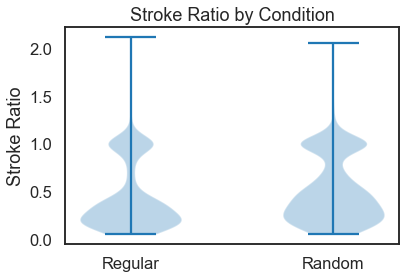

In [222]:
fig, axes = plt.subplots()
axes.violinplot(dataset = [[x for x in D[D.Regularity == 'regular']["strokeRatio"].values if str(x) != 'nan'],
                           [x for x in D[D.Regularity == 'random']["strokeRatio"].values if str(x) != 'nan']],
                points=1000)

axes.set_xticklabels(['','Regular','','Random'])
axes.set_ylabel("Stroke Ratio")
axes.set_title("Stroke Ratio by Condition")

Text(0.5, 1.0, 'Accuracy over Condition x Putative Strategy')

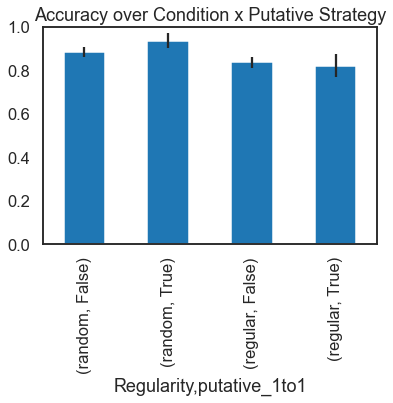

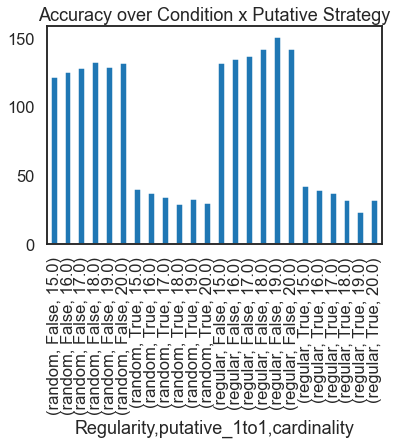

In [223]:
# plot the 2 x 2 of condition x strategy on accuracy
blah = get_confint(pd.DataFrame(D.groupby(['Regularity','putative_1to1']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot.bar(y='mean',yerr=blah['ci95_hi'] - blah['mean'],legend=None)
plt.title("Accuracy over Condition x Putative Strategy")
plt.ylim(0,1)
blah

# the same, but disaggregated over cardinality as well
bleh = get_confint(pd.DataFrame(D.groupby(['Regularity','putative_1to1','cardinality']).agg(['mean', 'count', 'std']))['outcome'])
bleh.plot.bar(y='count',legend=None)
plt.title("Accuracy over Condition x Putative Strategy")


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Number of Strokes / Stimulus Cardinality')

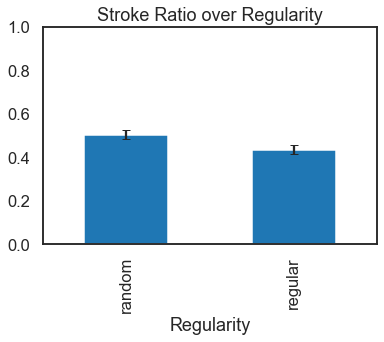

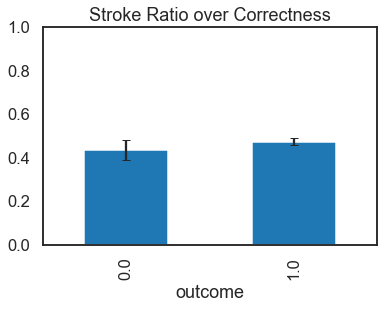

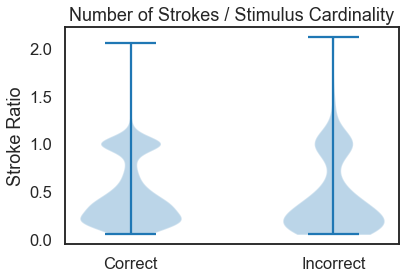

In [224]:
# plot the average number of strokes versus cardinality by condition
blah = get_confint(pd.DataFrame(D.groupby(['Regularity']).agg(['mean', 'count', 'std']))['strokeRatio'])
blah.plot.bar(y='mean',yerr=blah['ci95_hi'] - blah['mean'],legend=None,capsize=c)
plt.title("Stroke Ratio over Regularity")
plt.ylim(0,1)
 
# plot the average number of strokes versus cardinality by condition
blah = get_confint(pd.DataFrame(D.groupby(['outcome']).agg(['mean', 'count', 'std']))['strokeRatio'])
blah.plot.bar(y='mean',yerr=blah['ci95_hi'] - blah['mean'],legend=None,capsize=c)
plt.title("Stroke Ratio over Correctness")
plt.ylim(0,1)

fig, axes = plt.subplots()
axes.violinplot(dataset = [D[D.outcome == 1]["strokeRatio"].values,
                           [x for x in D[D.outcome == 0]["strokeRatio"].values if str(x) != 'nan']],
                points=1000)

axes.set_xticklabels(['','Correct','','Incorrect'])
axes.set_ylabel("Stroke Ratio")
axes.set_title("Number of Strokes / Stimulus Cardinality")

Text(0.5, 1.0, 'Number of Strokes / Stimulus Cardinality')

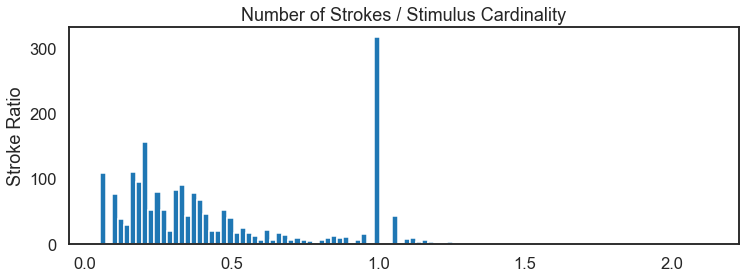

In [225]:
fig, axes = plt.subplots(figsize=(12,4))
X = np.array([x for x in D["strokeRatio"].values if str(x) != 'nan'])
axes.hist(X,bins=100)

# axes.set_xticklabels(['','Correct','','Incorrect'])
axes.set_ylabel("Stroke Ratio")
axes.set_title("Number of Strokes / Stimulus Cardinality")
# axes.axvline(x=0.62838291,c='r',ls='--',alpha=.5,lw=1)


In [ ]:
# # want to mix two Gaussians to the above histogram and intersect them for a cutoff point
# # maybe try https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137
# # or https://stackoverflow.com/questions/26902283/fit-multiple-gaussians-to-the-data-in-python
# # or https://stackoverflow.com/questions/16331983/scipy-kmeans-how-to-get-actual-threshold-between-clusters
# # or from R: http://marcchoisy.free.fr/fmm/index.html

# from sklearn.cluster import KMeans
# h = np.histogram(X,bins=100)
# h = np.vstack((0.5*(h[1][:-1]+h[1][1:]),h[0])).T  # because h[0] and h[1] have different sizes.

# kmeans = KMeans(n_clusters=2).fit(X.reshape(2051,1))
# print(kmeans.cluster_centers_)
# np.histogram(X,bins=100)

<AxesSubplot:xlabel='trialNum', ylabel='strokeRatio'>

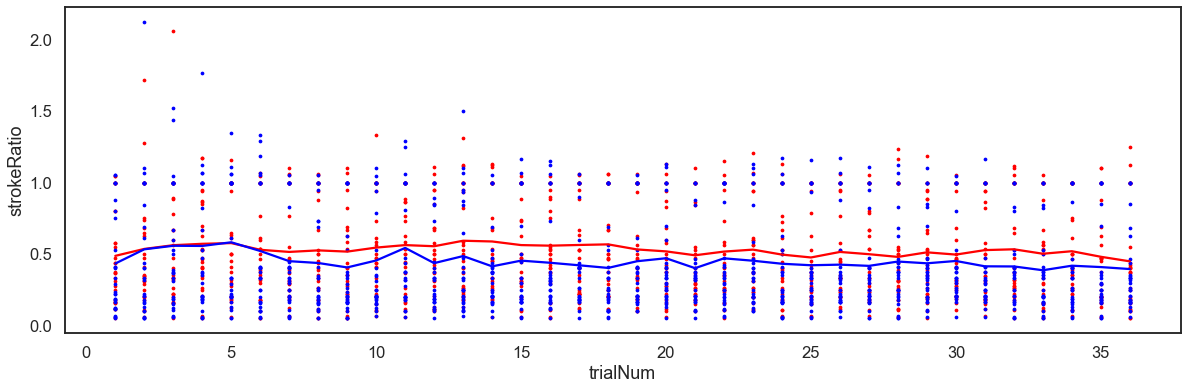

In [136]:
f , ax1 = plt.subplots(1,1,figsize=(20,6))
D[D['Regularity']=='random'].groupby(['trialNum'])['strokeRatio'].mean().plot(c='red',ax=ax1)
D[D['Regularity']=='regular'].groupby(['trialNum'])['strokeRatio'].mean().plot(c='blue',ax=ax1)

D[D['Regularity']=='random'].plot.scatter(x='trialNum',y='strokeRatio',marker='.',c='red',ax=ax1)
D[D['Regularity']=='regular'].plot.scatter(x='trialNum',y='strokeRatio',marker='.',c='blue',ax=ax1)

### Time

Text(0.5, 1.0, 'Draw Duration over Trials')

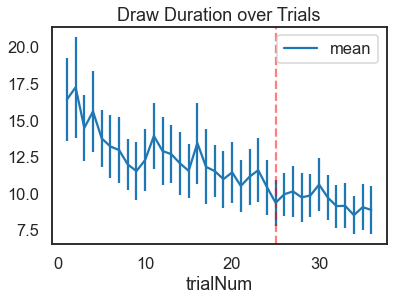

In [137]:
# plot the time spent drawing for each trial on average
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.axvline(x=25,c='r',ls='--',alpha=.5)
plt.title("Draw Duration over Trials")

### Ink Used

array([<AxesSubplot:title={'center':'meanPixelIntensity'}>], dtype=object)

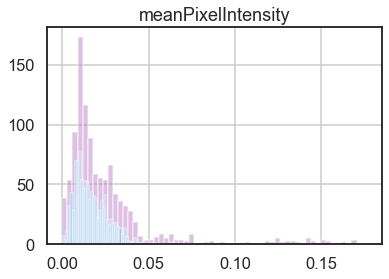

In [138]:
fig, ax1 = plt.subplots(1)
# plot the amount of ink used in each sketch
D[D['Regularity']=='regular'][['meanPixelIntensity']].hist(bins=60,color=condColours[1],alpha=.5,ax=ax1) #pink
D[D['Regularity']=='random'][['meanPixelIntensity']].hist(bins=60,color=condColours[0],alpha=.5,ax=ax1) #blue


### Other things over trials

Text(0.5, 1.0, 'NumStrokes over Trials')

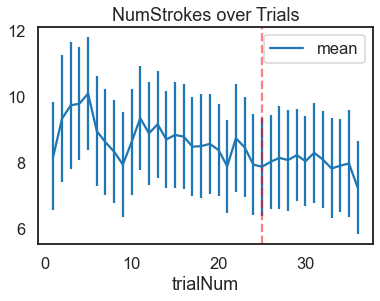

In [139]:
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['numStrokes'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.axvline(x=25,c='r',ls='--',alpha=.5)

plt.title("NumStrokes over Trials")

Text(0.5, 1.0, 'Ink over Trials')

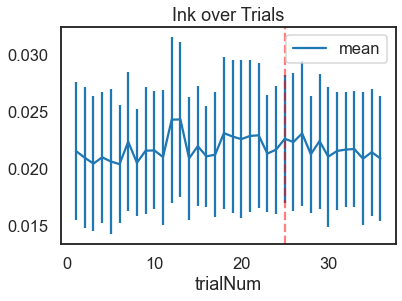

In [140]:
blah = get_confint(pd.DataFrame(D.groupby(['trialNum']).agg(['mean', 'count', 'std']))['meanPixelIntensity'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.axvline(x=25,c='r',ls='--',alpha=.5)
plt.title("Ink over Trials")

Text(0.5, 1.0, 'Accuracy over Cardinality')

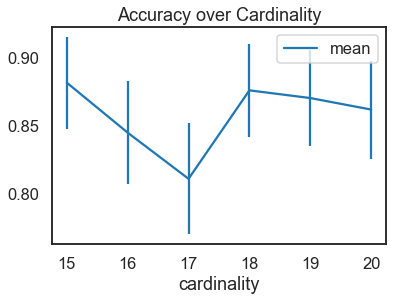

In [141]:
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['outcome'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Accuracy over Cardinality")

Text(0.5, 1.0, 'NumStrokes over Cardinality')

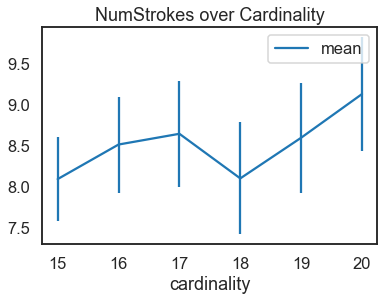

In [142]:
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['numStrokes'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("NumStrokes over Cardinality")

Text(0.5, 1.0, 'Draw Duration over Cardinality')

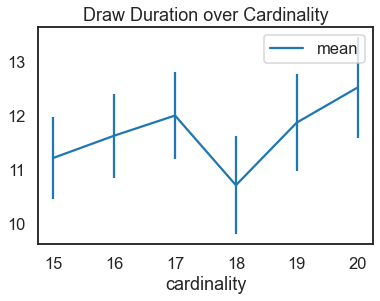

In [143]:
blah = get_confint(pd.DataFrame(D.groupby(['cardinality']).agg(['mean', 'count', 'std']))['drawDuration'])
blah.plot(y='mean',yerr=blah['ci95_hi'] - blah['mean'])
plt.title("Draw Duration over Cardinality")

In [226]:
D[['guess_animal','guess_cardinality']] = D.response.str.split("_",expand=True)
D = D.astype({'guess_cardinality': 'int'})
D = D.astype({'cardinality': 'int'})

D['distance'] = D.guess_cardinality - D.cardinality


<AxesSubplot:xlabel='guess_cardinality', ylabel='cardinality'>

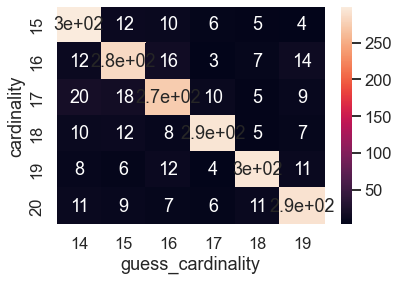

In [227]:
plt.pcolor(D[['cardinality','guess_cardinality']])

confmat = pd.crosstab(D['cardinality'], D['guess_cardinality'])

sns.heatmap(confmat, annot=True)


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0, 0.5, 'Draw Duration')

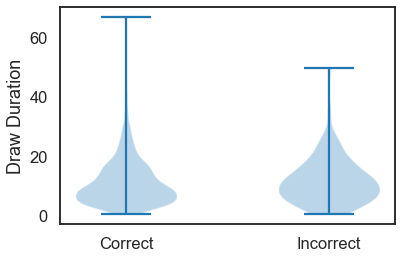

In [228]:
fig, axes = plt.subplots()

axes.violinplot(dataset = [D[D.outcome == 1]["drawDuration"].values,
                           [x for x in D[D.outcome == 0]["drawDuration"].values if str(x) != 'nan']],
                points=100)

axes.set_xticklabels(['','Correct','','Incorrect'])
axes.set_ylabel("Draw Duration")

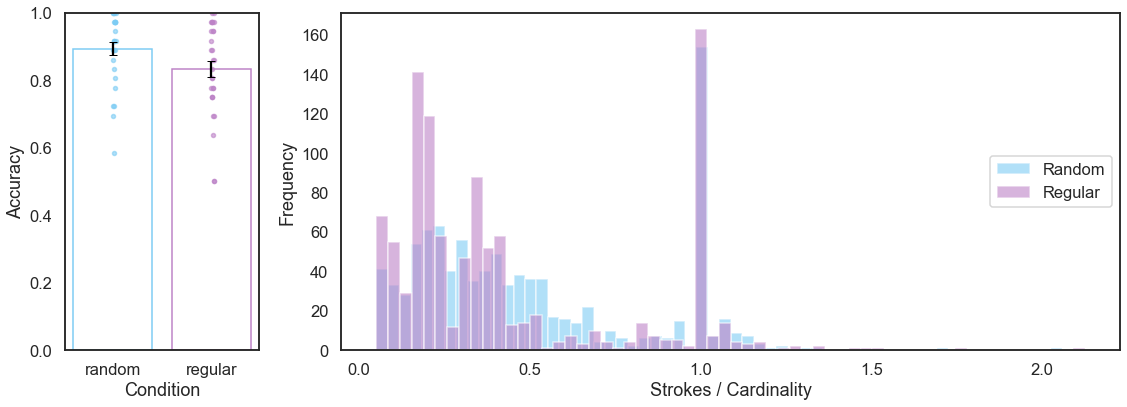

In [229]:
acc_DF = get_confint(pd.DataFrame(D.groupby(['Regularity'])['outcome'].agg(['mean', 'count', 'std'])))
subject_acc = pd.DataFrame(D.groupby(['Regularity','gameID'])['outcome'].mean()).reset_index()

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(16,6),gridspec_kw={'width_ratios': [2, 8]})
# fig.suptitle("Accuracy by Game Condition")
# ax1 = fig.add_subplot(1,2,1)

# ax1.set_title("Accuracy by Game Condition")

ax1.bar(acc_DF.reset_index()['Regularity'],
        height=acc_DF['mean'],
        width=.8,
        yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
        capsize=4)
ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Condition")

ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[1].set_edgecolor(condColours[0])
ax1.get_children()[2].set_edgecolor(condColours[1])


ran_acc_trial_DF = get_confint(pd.DataFrame(D[D['Regularity']=='random'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
reg_acc_trial_DF = get_confint(pd.DataFrame(D[D['Regularity']=='regular'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))

# show points as subject accuracies:
ran_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='random']['outcome'])
reg_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='regular']['outcome'])

ax1.scatter(0 + np.random.random(ran_subject_acc.size) * .03, ran_subject_acc, color=condColours[0],s=16,alpha=.6)
ax1.scatter(1 + np.random.random(reg_subject_acc.size) * .03, reg_subject_acc, color=condColours[1],s=16,alpha=.6)





# either do a histogram:
D[D['Regularity'] == 'random']['strokeRatio'].plot.hist(ax=ax2,color=condColours[0],alpha=.6,bins=60)
D[D['Regularity'] == 'regular']['strokeRatio'].plot.hist(ax=ax2,color=condColours[1],alpha=.6,bins=60)

# # or a density plot:
# bw = .1
# D[D['Regularity'] == 'random']['strokeRatio'].plot.density(ax=ax3,color='#7DCCF4',bw_method=bw)
# D[D['Regularity'] == 'regular']['strokeRatio'].plot.density(ax=ax3,color='#BD83C7',bw_method=bw)

ax2.legend(["Random","Regular"],loc='center right')
ax2.set_xlabel("Strokes / Cardinality")

plt.tight_layout()


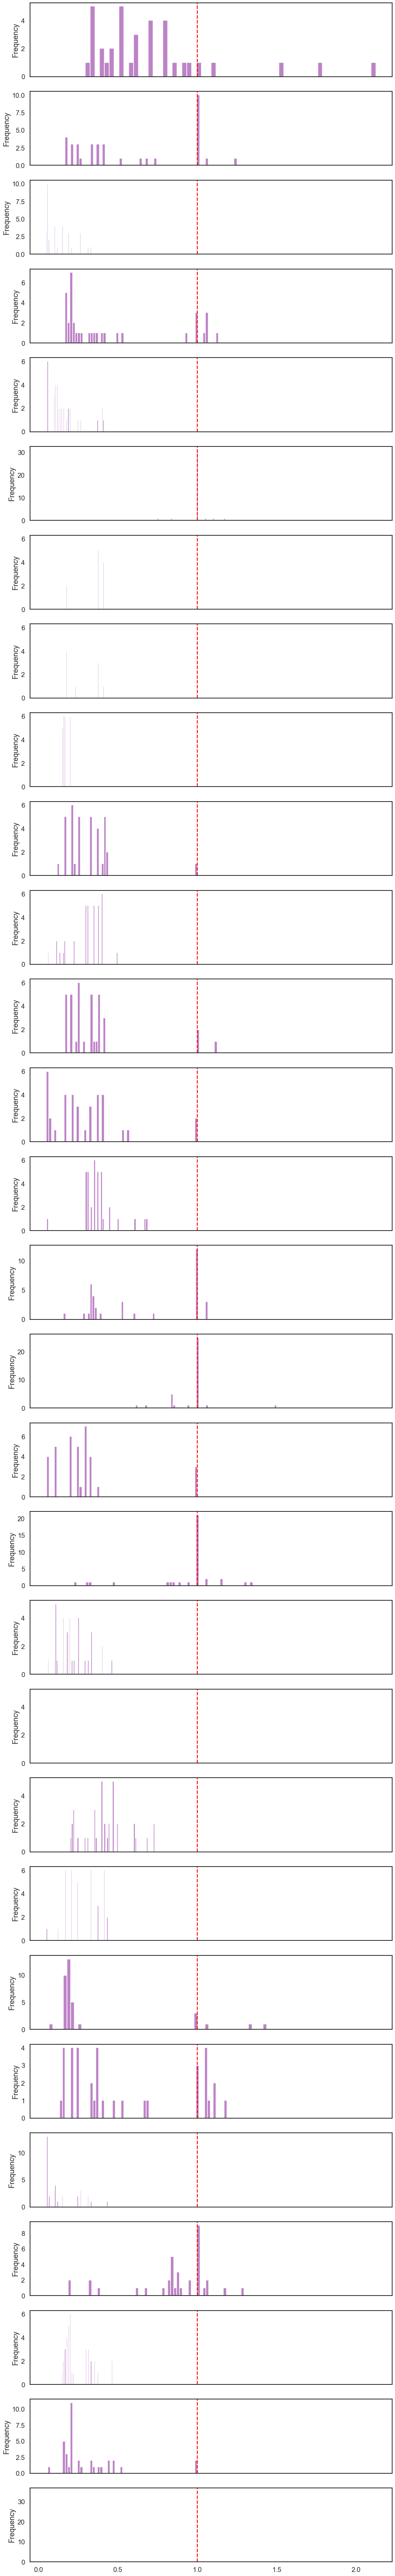

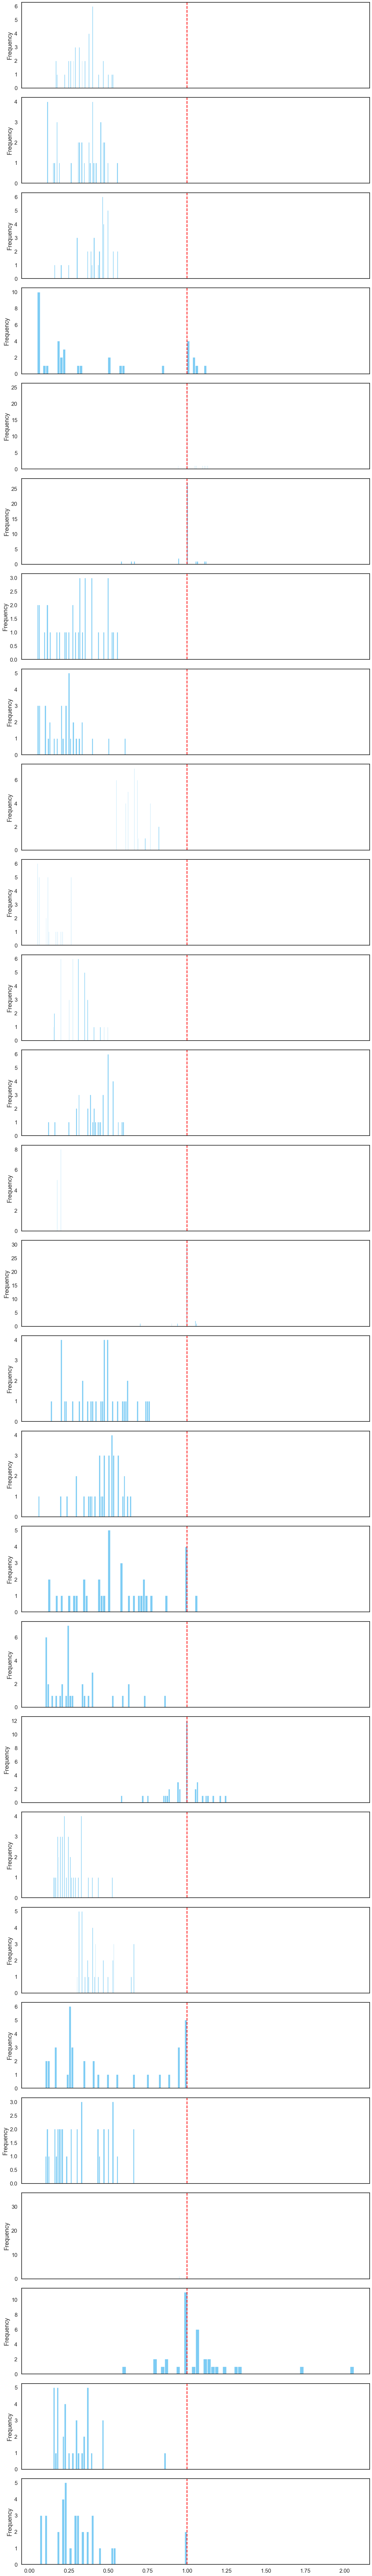

In [231]:
f , axsReg = plt.subplots(len(Dreg.gameID.unique()),1,figsize=(16,4*len(Dreg.gameID.unique())),sharex=True)
f , axsRan = plt.subplots(len(Dran.gameID.unique()),1,figsize=(16,4*len(Dran.gameID.unique())),sharex=True)




for i,game in enumerate(Dran.gameID.unique()):
    Dran[Dran['gameID']==game]['strokeRatio'].plot.hist(ax=axsRan[i],color=condColours[0],bins=60)
    axsRan[i].axvline(1,c='r',linestyle='--')

for i,game in enumerate(Dreg.gameID.unique()):
    Dreg[Dreg['gameID']==game]['strokeRatio'].plot.hist(ax=axsReg[i],color=condColours[1],bins=60)
    axsReg[i].axvline(1,c='r',linestyle='--')

# axs[-1].set_xlabel("Strokes / Cardinality")

plt.tight_layout()


# # or a density plot:
# bw = .1
# D[D['Regularity'] == 'random']['strokeRatio'].plot.density(ax=ax3,color='#7DCCF4',bw_method=bw)
# D[D['Regularity'] == 'regular']['strokeRatio'].plot.density(ax=ax3,color='#BD83C7',bw_method=bw)



LeveneResult(statistic=22.92615276875361, pvalue=1.8384549027891062e-06)


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


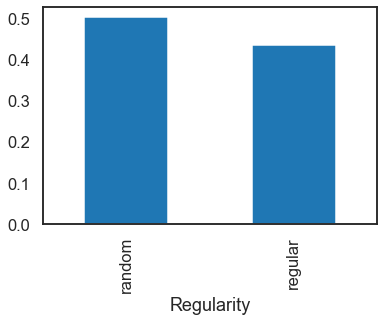

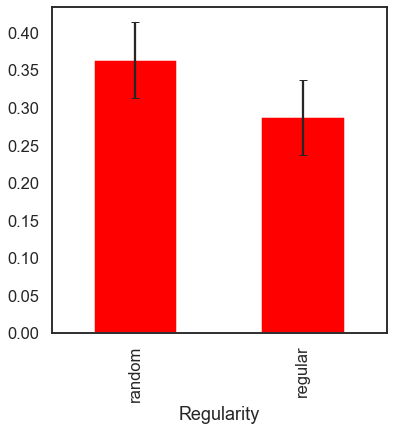

In [232]:
D.groupby(['Regularity','putative_1to1'])[['outcome']].agg(['mean','count','std'])
# D.columns

# D.groupby(['Regularity'])[['outcome']].agg(['mean','count','std'])['outcome']['mean'].plot.bar(ylim=(0,1))

D.groupby(['Regularity'])['strokeRatio'].mean().plot.bar()


temp = get_confint(D[D['putative_1to1']==False].groupby(['Regularity'])['strokeRatio'].agg(['mean','count','std']))

f , a = plt.subplots(1,1,figsize=(6,6))

temp.plot.bar(ax=a, y='mean',yerr=.05,capsize=4,legend=None,color='red',alpha=1)

re = D[D['putative_1to1']==False][D['Regularity']=='regular']['strokeRatio']
ra = D[D['putative_1to1']==False][D['Regularity']=='random'][np.isnan(D['strokeRatio'])==False]['strokeRatio']


# https://python-bloggers.com/2022/03/levenes-test-for-equality-of-variances-explained-with-python-examples/
from scipy.stats import levene
print(levene(re,ra))


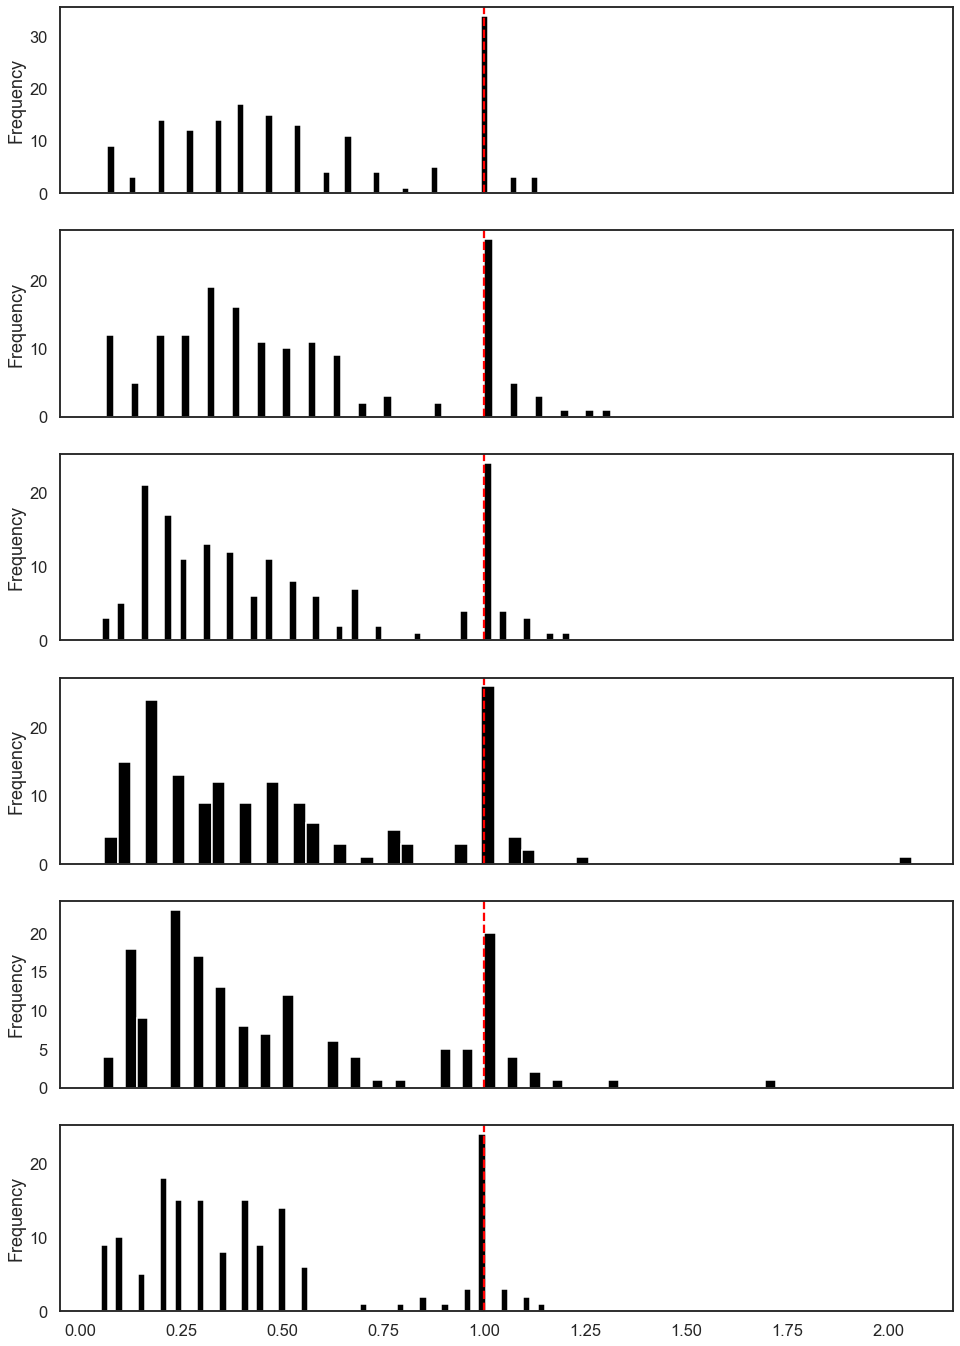

In [233]:
temp = D[D['Regularity']=='random']

# discretize into three bins: 1-to-1, less than, and more than
# then make a stacked bar plot
# then look to see if something hits you in the face with an obvious 
# ask Erik about the analyses

f , axsNum = plt.subplots(len(D.cardinality.unique()),1,figsize=(16,4*len(D.cardinality.unique())),sharex=True)

for i,cardinality in enumerate(D.cardinality.unique()):
    temp[temp['cardinality']==cardinality]['strokeRatio'].plot.hist(ax=axsNum[i],color='k',bins=60)
    axsNum[i].axvline(1,c='r',linestyle='--')


{'bodies': [<matplotlib.collections.PolyCollection object at 0x7ff33fb9d470>, <matplotlib.collections.PolyCollection object at 0x7ff33fb9ddd8>], 'cmaxes': <matplotlib.collections.LineCollection object at 0x7ff33fb929e8>, 'cmins': <matplotlib.collections.LineCollection object at 0x7ff33fbab828>, 'cbars': <matplotlib.collections.LineCollection object at 0x7ff33fbabac8>, 'cmedians': <matplotlib.collections.LineCollection object at 0x7ff33fbabd68>}


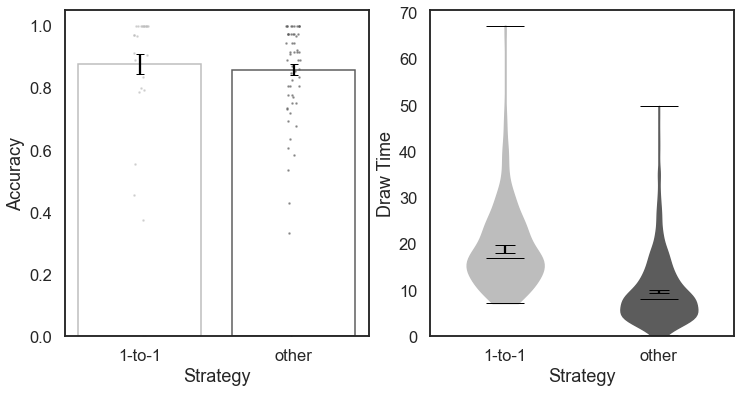

In [234]:


acc_DF = get_confint(pd.DataFrame(D.groupby(['strategy'])['outcome'].agg(['mean', 'count', 'std'])))
trial_acc = pd.DataFrame(D.groupby(['strategy','gameID'])['outcome'].mean()).reset_index()

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(12,6),gridspec_kw={'width_ratios': [2, 2]})
# fig.suptitle("Accuracy by Game Condition")
# ax1 = fig.add_subplot(1,2,1)

# ax1.set_title("Accuracy by Game Condition")

ax1.bar(acc_DF.reset_index()['strategy'],
        height=acc_DF['mean'],
        width=.8,
        yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
        capsize=4)
# ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Strategy")

ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[1].set_edgecolor(stratColours[0])
ax1.get_children()[2].set_edgecolor(stratColours[1])

one_acc_trial_DF = get_confint(pd.DataFrame(D[D['strategy']=='1-to-1'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
oth_acc_trial_DF = get_confint(pd.DataFrame(D[D['strategy']=='other'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))

# show points as trial accuracies:
one_subject_acc = np.array(trial_acc[trial_acc['strategy']=='1-to-1']['outcome'])
oth_subject_acc = np.array(trial_acc[trial_acc['strategy']=='other']['outcome'])

ax1.scatter(0 + np.random.random(one_subject_acc.size) * .1 - .05, one_subject_acc, color=stratColours[0],s=1,alpha=.6)
ax1.scatter(1 + np.random.random(oth_subject_acc.size) * .1 - .05, oth_subject_acc, color=stratColours[1],s=1,alpha=.6)

time_DF = get_confint(pd.DataFrame(D.groupby(['strategy'])['drawDuration'].agg(['mean', 'count', 'std'])))
trial_time = pd.DataFrame(D.groupby(['strategy','gameID','trialNum'])['drawDuration'].mean()).reset_index()

ax2.bar(time_DF.reset_index()['strategy'],
        height=time_DF['mean'],
        width=.8,
        yerr=[time_DF['ci95_hi']-time_DF['mean'], time_DF['mean']-time_DF['ci95_lo']],
        capsize=10)
# ax2.set_ylim([0,1])
ax2.set_ylabel("Draw Time")
ax2.set_xlabel("Strategy")

ax2.get_children()[1].set_color((0,0,0,0))
ax2.get_children()[2].set_color((0,0,0,0))
ax2.get_children()[1].set_edgecolor((0,0,0,0))#stratColours[0])
ax2.get_children()[2].set_edgecolor((0,0,0,0))#stratColours[1])

# show points as subject draw times:
one_subject_time = np.array(trial_time[trial_time['strategy'] == '1-to-1']['drawDuration'])
oth_subject_time = np.array(trial_time[trial_time['strategy'] == 'other']['drawDuration'])
oth_subject_time = oth_subject_time[~np.isnan(oth_subject_time)]

# ax2.scatter(0 + np.random.random(one_subject_time.size) * .3 - .15, one_subject_time, color=stratColours[0],s=1,alpha=.6)
# ax2.scatter(1 + np.random.random(oth_subject_time.size) * .3 - .15, oth_subject_time, color=stratColours[1],s=1,alpha=.6)

vplot = ax2.violinplot(dataset=[one_subject_time,
                        oth_subject_time],
                       positions=[0,1],
                       showmeans=False,showmedians=True)


for i,pc in enumerate(vplot['bodies']):
    pc.set_facecolor(stratColours[i])
    pc.set_edgecolor(stratColours[i])
    pc.set_alpha(1)

# Make all the violin statistics marks black:
for partname in ('cbars','cmins','cmaxes','cmedians'): # 'cmeans'
    vp = vplot[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1) if partname != 'cbars' else vp.set_linewidth(0)


print(vplot)

mean  count       std    ci95_hi    ci95_lo  \
strategy Regularity                                                     
1-to-1   random      22.753621    203  8.166197  23.877004  21.630238   
         regular     15.114702    205  6.805335  16.046301  14.183104   
other    random      11.364245    768  8.016937  11.931246  10.797244   
         regular      7.958128    839  4.697449   8.275988   7.640267   

                         yerr  
strategy Regularity            
1-to-1   random      2.246766  
         regular     1.863196  
other    random      1.134002  
         regular     0.635722

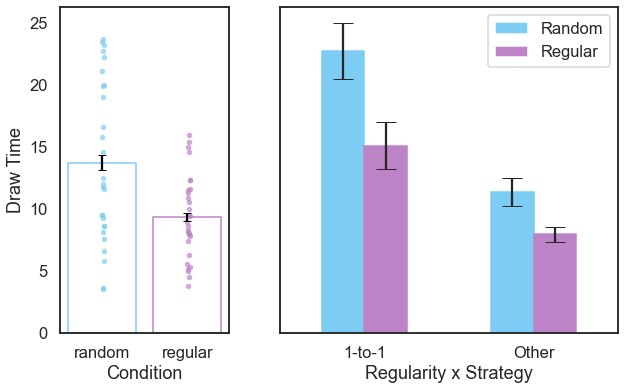

In [235]:
fig , (ax1,ax2)= plt.subplots(1,2,figsize=(10,6),gridspec_kw={'width_ratios': [2, 4]},sharey=True)

time_DF = get_confint(pd.DataFrame(D.groupby(['Regularity'])['drawDuration'].agg(['mean', 'count', 'std'])))
subject_time = pd.DataFrame(D.groupby(['Regularity','gameID'])['drawDuration'].mean()).reset_index()

ax1.bar(time_DF.reset_index()['Regularity'],
        height=time_DF['mean'],
        width=.8,
        yerr=[time_DF['ci95_hi']-time_DF['mean'], time_DF['mean']-time_DF['ci95_lo']],
        capsize=4)
# ax2.set_ylim([0,1])
ax1.set_ylabel("Draw Time")
ax1.set_xlabel("Condition")

ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[1].set_edgecolor(condColours[0])
ax1.get_children()[2].set_edgecolor(condColours[1])

# show points as subject draw times:
ran_subject_time = np.array(subject_time[subject_time['Regularity']=='random']['drawDuration'])
reg_subject_time = np.array(subject_time[subject_time['Regularity']=='regular']['drawDuration'])

ax1.scatter(0 + np.random.random(ran_subject_time.size) * .03, ran_subject_time, color=condColours[0],s=16,alpha=.6)
ax1.scatter(1 + np.random.random(reg_subject_time.size) * .03, reg_subject_time, color=condColours[1],s=16,alpha=.6)



# time_DF = get_confint(pd.DataFrame(D.groupby(['Regularity','strategy'])['drawDuration'].agg(['mean', 'count', 'std'])))
# time_DF.unstack().plot(y='mean',kind='bar',yerr='yerr',capsize=10,ax=ax2,rot=0,legend=stratColours).legend(
#     [Patch(facecolor=stratColours[0]),
#      Patch(facecolor=stratColours[1])],
#     ["1-1", "Other"])
# ax2.get_children()[2].set_color(stratColours[0]) # random x 1-1
# ax2.get_children()[3].set_color(stratColours[0]) # regular x 1-1
# ax2.get_children()[4].set_color(stratColours[1]) # random x other
# ax2.get_children()[5].set_color(stratColours[1]) # regular x other
# ax2.set_ylabel("Draw Time")
# ax2.set_xlabel("Regularity x Strategy")
# ax2.set_xticks([-.25,.12,.87,1.25])
# ax2.set_xticklabels(['N=   239','804','236','844 trials'])





time_DF = get_confint(pd.DataFrame(D.groupby(['strategy','Regularity'])['drawDuration'].agg(['mean', 'count', 'std'])))
time_DF.unstack().plot(y='mean',kind='bar',yerr='yerr',capsize=10,ax=ax2,rot=0,legend=stratColours).legend(
    [Patch(facecolor=condColours[0]),
     Patch(facecolor=condColours[1])],
    ["Random", "Regular"])
ax2.get_children()[2].set_color(condColours[0]) # random x 1-1
ax2.get_children()[3].set_color(condColours[0]) # random x other
ax2.get_children()[4].set_color(condColours[1]) # regular x 1-1
ax2.get_children()[5].set_color(condColours[1]) # regular x other

# ax2.get_children()[2].set_edgecolor(condColours[0]) # random x 1-1
# ax2.get_children()[3].set_edgecolor(condColours[0]) # random x other
# ax2.get_children()[4].set_edgecolor(condColours[1]) # regular x 1-1
# ax2.get_children()[5].set_edgecolor(condColours[1]) # regular x other
ax2.set_ylabel("Draw Time")
ax2.set_xlabel("Regularity x Strategy")
ax2.set_xticklabels(["1-to-1","Other"])

time_DF

## Figure for Manuscript

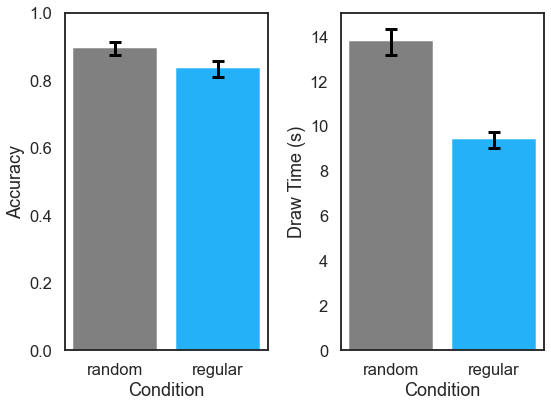

In [27]:


lw = 3
cs = 6

acc_DF = get_confint(pd.DataFrame(D.groupby(['Regularity'])['outcome'].agg(['mean', 'count', 'std'])))
subject_acc = pd.DataFrame(D.groupby(['Regularity','gameID'])['outcome'].mean()).reset_index()

fig , (ax1,ax2)= plt.subplots(1,2,figsize=(8,6),gridspec_kw={'width_ratios': [2, 2]})
# fig.suptitle("Accuracy by Game Condition")
# ax1 = fig.add_subplot(1,2,1)

# ax1.set_title("Accuracy by Game Condition")

ax1.bar(acc_DF.reset_index()['Regularity'],
        height=acc_DF['mean'],
        width=.8,
        yerr=[acc_DF['ci95_hi']-acc_DF['mean'], acc_DF['mean']-acc_DF['ci95_lo']],
        error_kw=dict(lw=lw, capsize=cs, capthick=lw))
ax1.set_ylim([0,1])
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Condition")

ax1.get_children()[1].set_color('grey') # was hollow, as (0,0,0,0)
ax1.get_children()[2].set_color('#25B1F7') # was hollow, as (0,0,0,0)
ax1.get_children()[1].set_edgecolor('grey')
ax1.get_children()[2].set_edgecolor('#25B1F7')


ran_acc_trial_DF = get_confint(pd.DataFrame(D[D['Regularity']=='random'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))
reg_acc_trial_DF = get_confint(pd.DataFrame(D[D['Regularity']=='regular'].groupby(['trialNum'])['outcome'].agg(['mean', 'count', 'std'])))

# show points as subject accuracies:
ran_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='random']['outcome'])
reg_subject_acc = np.array(subject_acc[subject_acc['Regularity']=='regular']['outcome'])

# ax1.scatter(0 + np.random.random(ran_subject_acc.size) * .03, ran_subject_acc, color='grey',s=16,alpha=.6)
# ax1.scatter(1 + np.random.random(reg_subject_acc.size) * .03, reg_subject_acc, color='#25B1F7',s=16,alpha=.6)







time_DF = get_confint(pd.DataFrame(D.groupby(['Regularity'])['drawDuration'].agg(['mean', 'count', 'std'])))
subject_time = pd.DataFrame(D.groupby(['Regularity','gameID'])['drawDuration'].mean()).reset_index()

ax2.bar(time_DF.reset_index()['Regularity'],
        height=time_DF['mean'],
        width=.8,
        yerr=[time_DF['ci95_hi']-time_DF['mean'], time_DF['mean']-time_DF['ci95_lo']],
        error_kw=dict(lw=lw, capsize=cs, capthick=lw))
# ax2.set_ylim([0,1])
ax2.set_ylabel("Draw Time (s)")
ax2.set_xlabel("Condition")

ax2.get_children()[1].set_color('grey') # was hollow, as (0,0,0,0)
ax2.get_children()[2].set_color('#25B1F7') # was hollow, as (0,0,0,0)
ax2.get_children()[1].set_edgecolor('grey')
ax2.get_children()[2].set_edgecolor('#25B1F7')

# show points as subject draw times:
ran_subject_time = np.array(subject_time[subject_time['Regularity']=='random']['drawDuration'])
reg_subject_time = np.array(subject_time[subject_time['Regularity']=='regular']['drawDuration'])

# ax2.scatter(0 + np.random.random(ran_subject_time.size) * .03, ran_subject_time, color='grey',s=16,alpha=.6)
# ax2.scatter(1 + np.random.random(reg_subject_time.size) * .03, reg_subject_time, color='#25B1F7',s=16,alpha=.6)



plt.tight_layout()

fig.savefig('../results/plots/accTimeExpt2.pdf')



<Figure size 432x288 with 0 Axes>

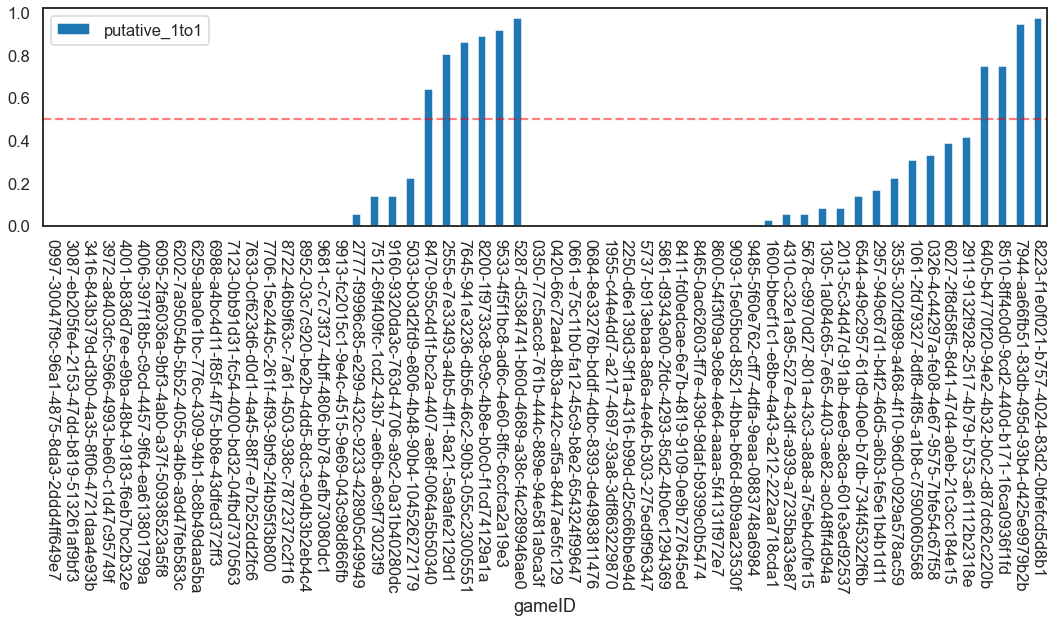

<Figure size 432x288 with 0 Axes>

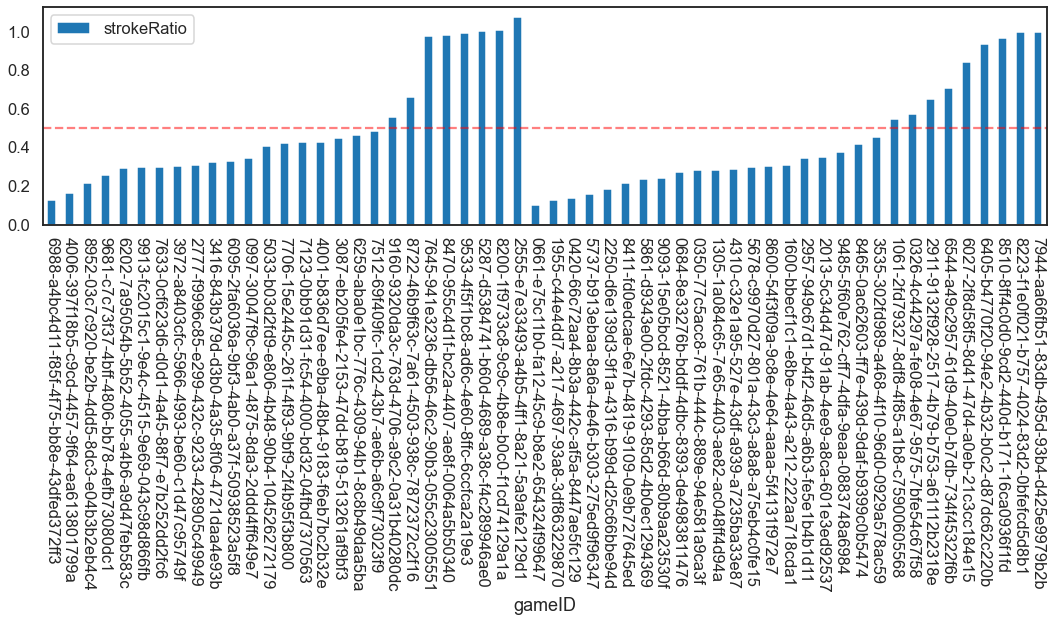

In [236]:

# 'random' is on the left, 'regular' is on the right
plt.figure()
D.groupby('gameID')[['Regularity','putative_1to1']].agg({'Regularity':(lambda x: True if x.all() == 'regular' else False),
                                                         'putative_1to1':'mean'}
                                                       ).sort_values(['Regularity','putative_1to1']).plot.bar(y='putative_1to1',
                                                                                                 rot=270,
                                                                                                 figsize=(18,4))
plt.axhline(y=.5,c='r',ls='--',alpha=.5)

plt.figure()
D.groupby('gameID')[['Regularity','strokeRatio']].agg({'Regularity':(lambda x: True if x.all() == 'regular' else False),
                                                         'strokeRatio':'mean'}
                                                       ).sort_values(['Regularity','strokeRatio']).plot.bar(y='strokeRatio',
                                                                                                 rot=270,
                                                                                                 figsize=(18,4))
plt.axhline(y=.5,c='r',ls='--',alpha=.5)



### <a name="isi"></a> Inter-Stroke Interval Measures ([^](#top))

#### <a name="isi-plots"></a> Plot things that might be interesting  ([^](#top))

<AxesSubplot:title={'center':'ISI - StrokeTime'}, xlabel='regularity'>

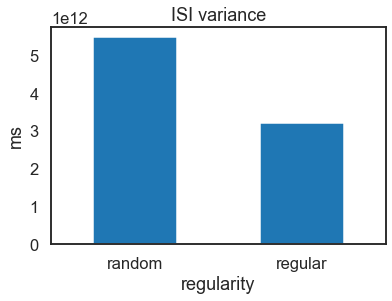

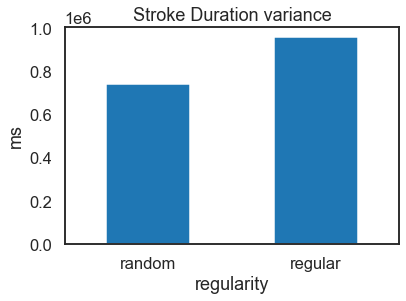

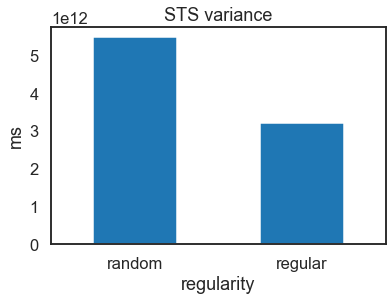

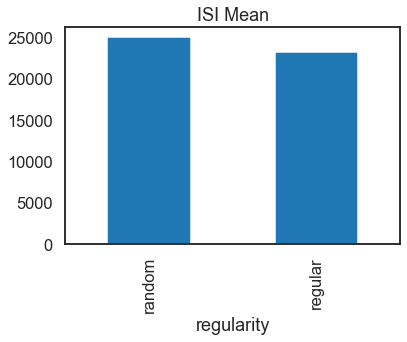

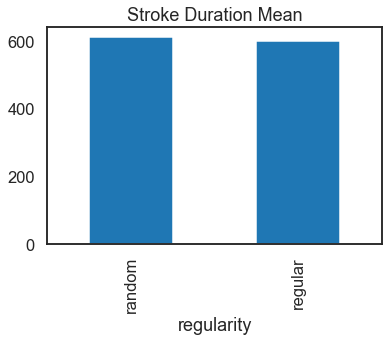

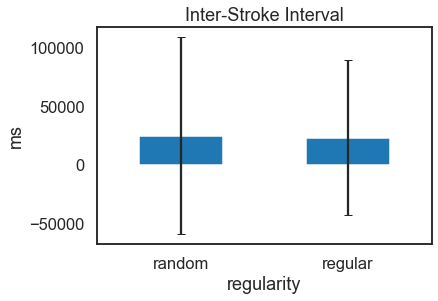

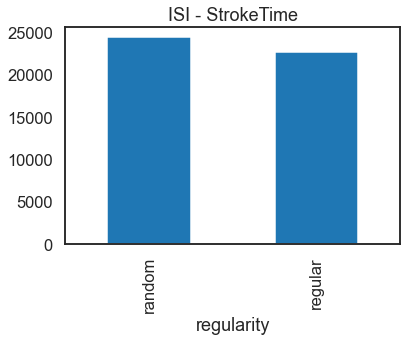

In [19]:
# look at variance of ISI in each condition
T.groupby(['regularity'])[['isi']].var().plot.bar(legend=None,
                                                  title="ISI variance",
                                                  ylabel="ms",rot=0)


T.groupby(['regularity'])[['strokeDur']].var().plot.bar(legend=None,
                                                        title="Stroke Duration variance",
                                                        ylabel="ms",rot=0)


T.groupby(['regularity'])[['sts']].var().plot.bar(legend=None,
                                                  title="STS variance",
                                                  ylabel="ms",rot=0)

# look at variance of ISI in each condition
T.groupby(['regularity'])[['isi']].mean().plot.bar(legend=None,title="ISI Mean")

T.groupby(['regularity'])[['strokeDur']].mean().plot.bar(legend=None,title="Stroke Duration Mean")



# (T.groupby(['regularity'])['isi'].mean() + T.groupby(['regularity'])['strokeDur'].mean()).plot.bar(legend=None,title="Combined Mean")

# T.groupby(['regularity'])['isi'].mean() + T.groupby(['regularity'])['strokeDur'].mean()

# look at std of isi in each condition
blah = get_confint(pd.DataFrame(T.groupby(['regularity']).agg(['mean', 'count', 'std']))['isi'])
blah.plot.bar(y='mean',
              yerr=blah['ci95_hi'] - blah['ci95_lo'],
              capsize=c,
              legend=None,title="Inter-Stroke Interval",rot=0,ylabel="ms")
strat2.set_title("Inter-Stroke Interval")
# strat2.set_ylim(0,1)
strat2.set_xlabel("")

# compare reaction time (ISI) to draw duration of the stroke:
T.groupby(['regularity'])[['timeDiff']].mean().plot.bar(legend=None,title="ISI - StrokeTime")

# GINI coefficient of ISI ?

#### <a name="isi-timecourse"></a> Visualize all strokes timecourse from every trial ([^](#top))

In [ ]:
# # 'sRT' is really a measure of elapsed trial time over multiple events...
# regGames = T[T['regularity']=='regular'].gameid.unique()
# ranGames = T[T['regularity']=='random'].gameid.unique()

# f, axs = plt.subplots(len(T.gameid.unique()),1,figsize=(16,len(T.gameid.unique())*4),sharex=True)

# for i,game in enumerate(regGames):
#     T[T['gameid']==game][T['trialNum']%2==0].plot.scatter(ax=axs[i],x='sRT',y='trialNum',c='b',s=5,xlim=(0,20000))
#     T[T['gameid']==game][T['trialNum']%2!=0].plot.scatter(ax=axs[i],x='sRT',y='trialNum',c='k',s=5,xlim=(0,20000))
# for i,game in enumerate(ranGames):
#     T[T['gameid']==game][T['trialNum']%2==0].plot.scatter(ax=axs[i+len(regGames)],x='sRT',y='trialNum',c='r',s=5,xlim=(0,20000))
#     T[T['gameid']==game][T['trialNum']%2!=0].plot.scatter(ax=axs[i+len(regGames)],x='sRT',y='trialNum',c='brown',s=5,xlim=(0,20000))


#### <a name="bootstrap"></a> Bootstrap ISI Variance ([^](#top))

In [20]:
def getCI95(x):
    upper = np.mean(x) + 1.96*np.std(x)/math.sqrt((len(x)))
    lower = np.mean(x) - 1.96*np.std(x)/math.sqrt((len(x)))
    return upper - lower


In [21]:
# now exclude bad trials (where viewer started too early or sketcher made tea)
# and do bootstrapping



# first the exclusions (see if we get similar results with and without)
hiCutoff = T.isi.mean() + T.isi.std()*3
loCutoff = T.isi.mean() - T.isi.std()*3

# np.mean(T.isi < hiCutoff)
print(len(T))

Tex = T[T.isi < hiCutoff][T.isi > loCutoff][T.firstStroke != True]
Tex['isi'] = Tex['isi'] / 1000
print(len(Tex))



23358


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


19835


<AxesSubplot:xlabel='gameid'>

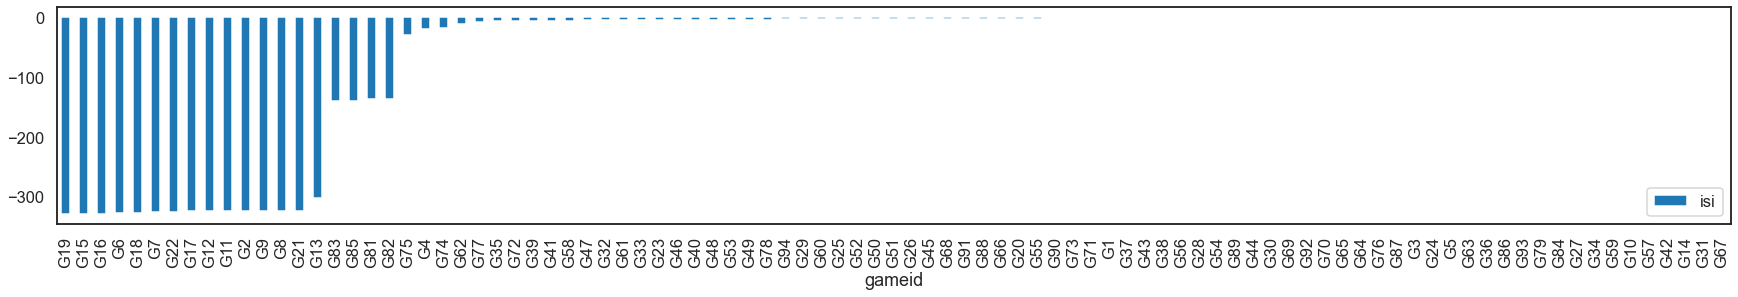

In [53]:
# Tex.firstStroke#['isi']

Tex.groupby(['gameid'])[['isi']].min().sort_values('isi').plot.bar(figsize=(30,4))

<AxesSubplot:title={'center':'ISI on every stroke of sketch, all games'}, xlabel='currStrokeNum', ylabel='ISI'>

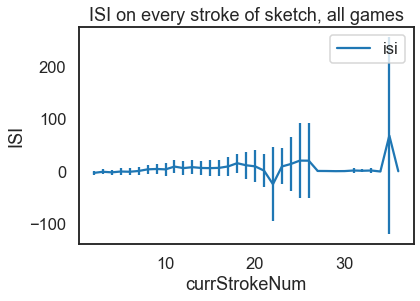

In [40]:
# this is wrong. Negative ISI shouldn't be possible, so the measure is wrong
Tex.groupby(['currStrokeNum'])[['isi']].mean().plot(title="ISI on every stroke of sketch, all games",
                                                    ylabel="ISI",
                                                    yerr=Tex.groupby(['currStrokeNum'])[['isi']].apply(lambda x: getCI95(x)))


# Tex.groupby(['currStrokeNum'])[['isi']].apply(lambda x: getCI95(x))#.plot()

<AxesSubplot:xlabel='gameid', ylabel='isi'>

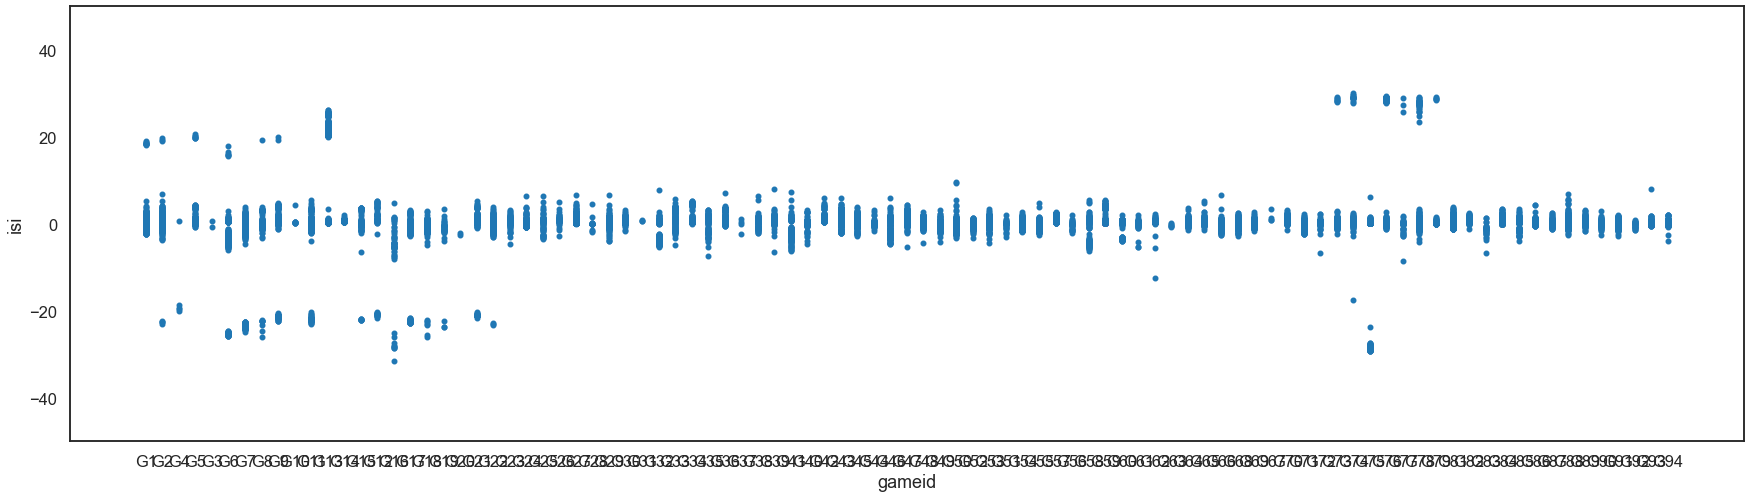

In [47]:
Tex.plot.scatter(x='gameid',y='isi',figsize=(30,8),ylim=(-50,50))   # logy=True




Text(0, 0.5, 'Variance (95-CI)')

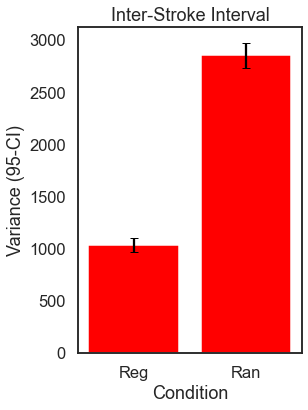

In [46]:

Treg = Tex[Tex['regularity']=='regular']
Tran = Tex[Tex['regularity']=='random']

regTakes = np.zeros([0,1])
ranTakes = np.zeros([0,1])

for take in range(1000):
    # should use arithmetic mean or geometric (stats.gmean())?
    regMean = np.mean(Treg.groupby(['gameid'])[['isi']].var().sample(30,
                                                   replace=True,
                                                   random_state=take)['isi'])
    regTakes = np.append(regTakes,np.array([[regMean]]),axis=0)
    
    # should use arithmetic mean or geometric (stats.gmean())?
    ranMean = np.mean(Tran.groupby(['gameid'])[['isi']].var().sample(30,
                                                   replace=True,
                                                   random_state=take)['isi'])
    ranTakes = np.append(ranTakes,np.array([[ranMean]]),axis=0)


f, (ax1) = plt.subplots(1,1,figsize=(4,6),sharey=True)

# f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6),sharey=True)

# ax1.plot.bar(y='mean',yerr=RegVar['ci95_hi'] - RegVar['mean'],
#             capsize=c,legend=None,color='orange')

# ax2.plot.bar(y='mean',yerr=RanVar['ci95_hi'] - RanVar['mean'],
#             capsize=c,legend=None,color='purple')

ax1.bar(["Reg","Ran"],[np.mean(regTakes),np.mean(ranTakes)],
        color='r',yerr=[getCI95(regTakes),getCI95(ranTakes)],capsize=4)
ax1.set_title("Inter-Stroke Interval")
ax1.set_xlabel("Condition")
ax1.set_ylabel("Variance (95-CI)")

# ax2.bar(["Reg","Ran"],[stats.gmean(regTakes)[0],stats.gmean(ranTakes)[0]],
#         color='g',yerr=[stats.gstd(regTakes)[0],stats.gstd(ranTakes)[0]],capsize=4)
# ax2.set_xlabel("Variance (Geometric STD)")
# ax1.yaxis.get_major_formatter().set_scientific(False)
# ax2.yaxis.get_major_formatter().set_scientific(False)


In [47]:
# super exclusive T, where we get rid of all instances where the ISI exceeds 15 seconds
Texex = Tex[Tex['isi'] <= 15]

print(len(Tex))
print(len(Texex))

15832
14648


In [28]:

takes = np.zeros([0,1])

for take in range(1000):
    # sample a whole bunch of trials at random
    Mean = np.mean(Texex.groupby(['gameid'])[['isi']].var().sample(50,
                                                   replace=True,
                                                   random_state=take)['isi'])
    takes = np.append(takes,np.array([[Mean]]),axis=0)
    


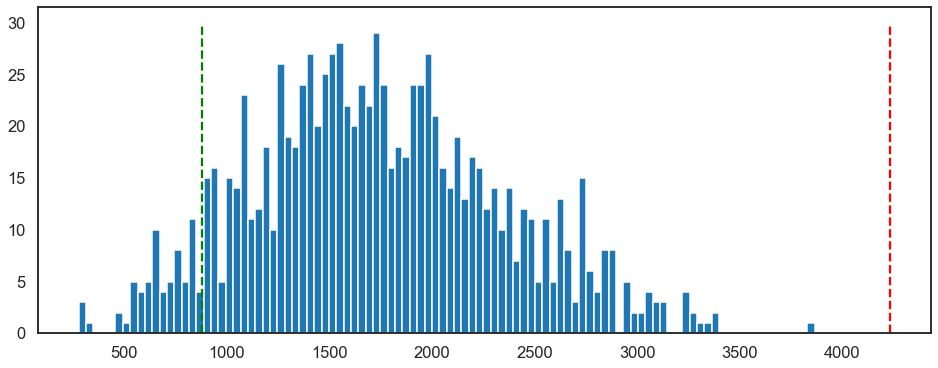

In [29]:
f , ax = plt.subplots(1,1,figsize=(16,6))
ax.hist(takes,bins=100)
print("")
TexexRanvar = float(Texex[Texex['regularity'] == 'random'][['isi']].var())
TexexRegvar = float(Texex[Texex['regularity'] == 'regular'][['isi']].var())
ax.vlines(TexexRanvar,0,30,linestyle='--',color='r')
ax.vlines(TexexRegvar,0,30,linestyle='--',color='g')

In [30]:
print("1-Tail P-Values:\n\nRegular: {}\nRandom:  {}".format(np.mean(takes < TexexRegvar),np.mean(takes > TexexRanvar)))

1-Tail P-Values:

Regular: 0.067
Random:  0.0


In [ ]:
# t = (x̄ - μ) / (s / √n)

t_ran = (TexexRanvar - np.mean(takes)) / (np.std(takes) / np.sqrt(len(takes)))
t_reg = (TexexRegvar - np.mean(takes)) / (np.std(takes) / np.sqrt(len(takes)))

t_ran

In [33]:
dfT = Texex

takes = np.zeros([0,1])

for take in range(1000):
    # sample a whole bunch of trials at random
    temp = dfT.groupby(['gameid'])[['isi']].var().sample(59,
                                                        replace=False,
                                                        random_state=50)['isi']
    partition1 = temp[0:30] # len = 30
    partition2 = temp[30: ] # len = 29
    
    takes = np.append(takes,np.array([[regMean]]),axis=0)
    


In [34]:
temp = dfT.groupby(['gameid'])[['isi']].var().sample(59,
                                                    replace=False,
                                                    random_state=50)['isi']
partition1 = temp[0:30] # len = 30
partition2 = temp[30: ] # len = 29

np.std(partition2)

3108.873560729534

In [ ]:
# import inspect
# print(inspect.getsource(stats.ttest_ind))
# dir(inspect)



In [35]:
import scipy
scipy.__version__

'1.7.3'

In [47]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

for i in np.arange(0,.5,.02):
    print(stats.ttest_ind(dfT[dfT['regularity'] == 'random']['isi'],
                    dfT[dfT['regularity'] == 'regular']['isi'],
                    permutations=1000,
                    equal_var=False,
                    random_state=20))

Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResult(statistic=-18.04779836654343, pvalue=0.0)
Ttest_indResul

In [81]:
stats.ttest_ind(dfT[dfT['regularity'] == 'random']['isi'],
                    dfT[dfT['regularity'] == 'regular']['isi'], trim=.11)

Ttest_indResult(statistic=-16.8708002493508, pvalue=2.9615375013173854e-63)

In [59]:
t = []
p = []
for i in np.arange(0,.5,.01):
    test = stats.ttest_ind(dfT[dfT['regularity'] == 'random']['isi'],
                    dfT[dfT['regularity'] == 'regular']['isi'], trim=i)
    t = np.append(t,test[0])
    p = np.append(p,test[1])
    

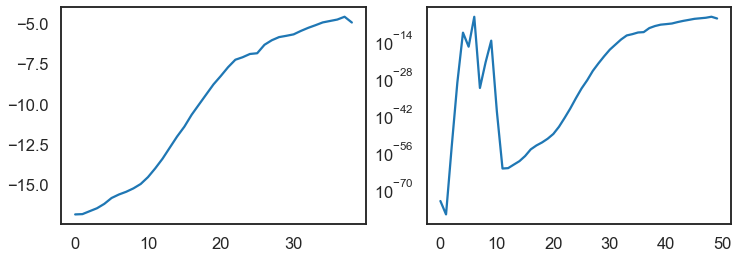

In [80]:
f , (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(t[11:])
ax2.plot(p)
ax2.set_yscale('log')

In [ ]:
Tex.groupby(['gameid'])[['isi']].var().plot.bar(figsize=(16,6),ylabel="ISI Variance",
                                                                            logy=True)

# Tex[['isi']].plot.hist(figsize=(16,10),logy=True,bins=100)

In [ ]:
# make a new column for ISI in terms of seconds
T['isi_seconds'] = T['isi'] / 1000

In [ ]:
T[T['regularity'] == 'random'].groupby(['gameid'])[['isi']].var().plot.bar(figsize=(16,6),
                                                                           logy=True)
T[T['regularity'] == 'regular'].groupby(['gameid'])[['isi']].var().plot.bar(figsize=(16,6),
                                                                            logy=True)

T.groupby(['gameid'])[['isi_seconds']].var().plot.bar(figsize=(16,6),
                                                                            logy=True)

In [ ]:
T._id

In [14]:
# blah = get_confint(pd.DataFrame(Dreg.groupby(['trialNum']).agg(['mean', 'count', 'std']))['outcome'])
# blah.plot(ax=trials1, y='mean',yerr=blah['ci95_hi'] - blah['mean'],capsize=c,legend=None,color='#5a9acc',alpha=a)


pd.DataFrame(T.groupby(['gameid']).agg(['mean', 'count', 'std']))['outcome']



In [ ]:
D.groupby('trialNum')[['drawDuration']].median().plot(figsize=(12,3),logy=True)
D.groupby('trialNum')[['drawDuration']].median().plot(figsize=(12,3),logy=False)

D.groupby('trialNum')[['vRT']].median().plot(figsize=(12,3),logy=True)
D.groupby('trialNum')[['vRT']].median().plot(figsize=(12,3),logy=False)
f , ax1 = plt.subplots(1,1,figsize=(12,3))
ax1.set_ylim([0, 1.5])

D[D['Regularity']=='regular'].groupby('trialNum')[['strokeRatio']].mean().plot(ax=ax1)
D[D['Regularity']=='random'].groupby('trialNum')[['strokeRatio']].mean().plot(ax=ax1,color='r')


In [ ]:
# define two functions to help us cluster strokes and render them, respectively

def newKmeans(df,k=3):
    """ This function takes a DF grouped by gameid and trialnum,
    where the rows are all strokes of one sketch. We first find centroids,
    then cluster into k clusters, and spit out a list of cluster assignments.
    """
    # first step might be better done with shapely:
    # https://geobgu.xyz/py/shapely.html#centroids-shapely
    # find centroids first, then put them into a bundle
    # so here we compute centroids for every stroke
    centroid_list = np.zeros([0,2]) # we don't know how long it'll be yet, but it's 2-D
    for row in df: # for every stroke in this game-trialnNum combo (sketch)
        rowStart = re.split('[a-zA-Z]', row)[1].split(',') # assumes 'M' is first command
        startPos = np.array(list(map(int, rowStart))) # get the starting position
        curve = re.split('[a-zA-Z]', row)[2].split(' ')[-1].split(',') # assumes 'c'
        endPos = startPos + np.array(list(map(int,curve))) #from relative to absolute coords
        centroid = startPos + ((endPos - startPos) / 2) # just take Euclidean midpoint
        centroid_list = np.append(centroid_list,np.array([centroid]),axis=0) # add to list!
    
    # we may have specified more clusters than there are strokes. So give it a floor:
    k = k if k < len(df) else len(df)
    
    # apply k-means clustering
    X = list(centroid_list)
    num_clusters = k # how many clusters?
    kmeans = KMeans(num_clusters, random_state=0).fit(X)
    cluster_inds = kmeans.labels_ ## get cluster indices
    
    kstats = {'inertia':kmeans.inertia_,
              'numIters':kmeans.n_iter_}
    return (list(df),list(centroid_list),cluster_inds,kmeans.inertia_)

def drawSVG(df):
    """This takes a DF generated by newKmeans() and renders out the sketches,
    with colours assigned for each cluster (assuming k=3 clusters for now)"""
    colors = [(20, 50, 80),(0, 10, 0),(70, 70, 0)] # rbg values for k colours
    for row in df.iterrows():
        # find out the game and trial number
        gameid = str(row[0][0])
        trialnum = str(row[0][1])
        animal = str(row[0][2])
        cardinality = str(row[0][3])
        name = gameid + "_t=" + trialnum + "_" + cardinality + "_" + animal + ".svg"
        # instantiate a blank drawing of the correct size
        drawing = svgwrite.Drawing('../clustered_sketches/'+name,
                                   size=('300px', '300px'),
                                   profile='tiny') 

        svgdata = row[1]['svgData']
        
        # now for every stroke, add it to the sketch,
        # with colour specified by cluster membership
        for i,stroke in enumerate(svgdata):

            c = colors[row[1]['clusters'][i]] # find the color for the correct cluster
            drawing.add(drawing.path(d=stroke,
                                     stroke=svgwrite.rgb(c[0], c[1], c[2], '%'),
                                     fill="none",
                                     stroke_width=6))
        drawing.save()

In [ ]:
# make a small dataframe from one trial to test out on
smallDF = T[T['trialNum']==2][T['gameid']=='G4']

# a slightly bigger one
medDF = T[T['gameid']=='G4']

# first get the info we'll need to do the clustering / rendering
grouped = medDF.groupby(['regularity','gameid','trialNum','animal','cardinality'])['svgData']

# now do the clustering - get the svg data, the centroids, and the cluster assignments
smallSVG = grouped.apply(lambda x: newKmeans(x)[0]).to_frame()
smallSVG['centroids'] = smallSVG['svgData'].apply(lambda x: newKmeans(x)[1])
smallSVG['clusters'] = smallSVG['svgData'].apply(lambda x: newKmeans(x)[2])

for k in range(10):
    smallSVG[k+1] = smallSVG['svgData'].apply(lambda x: newKmeans(x,k=k+1)[3])

In [ ]:
# https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet

smallSVG[[1,2,3,4,5,6,7,8,9,10]].T.plot(legend=None,ylabel="Kmeans Inertia")


In [ ]:
# first get the info we'll need to do the clustering / rendering
grouped = T.groupby(['regularity','gameid','trialNum','animal','cardinality'])['svgData']

# now do the clustering - get the svg data, the centroids, and the cluster assignments
svgDF = grouped.apply(lambda x: newKmeans(x)[0]).to_frame()
svgDF['centroids'] = svgDF['svgData'].apply(lambda x: newKmeans(x)[1])
svgDF['clusters'] = svgDF['svgData'].apply(lambda x: newKmeans(x)[2])
svgDF['inertia'] = svgDF['svgData'].apply(lambda x: newKmeans(x)[3])

In [ ]:
# # draw the clustered svg files out onto real files
# drawSVG(svgDF)


In [ ]:
for k in [2,3,4,5,6,7]:
    inertCol = 'inertia_K'+str(k)
    svgDF[inertCol] = svgDF['svgData'].apply(lambda x: newKmeans(x,k=k)[3])

In [ ]:
conditionInertia = svgDF.groupby(['regularity'])[inertCol].agg(['mean','std','count'])
conditionInertia['yerr'] = svgDF.groupby(['regularity'])[inertCol].agg(lambda x: getCI95(x))


In [ ]:
conditionInertia.plot.bar(y='mean',yerr='yerr',capsize=4,rot=0,
                          title="KMeans (k≤{}) Inertia by Condition".format(str(k)))

In [ ]:
inertiaDF = pd.DataFrame({'random':[0],
                          'ran_yerr':[0],
                          'regular':[0],
                          'reg_yerr':[0]},index=[2,3,4,5,6,7])

for n in [2,3,4,5,6,7]:
    conditionInertia = svgDF.groupby(['regularity'])['inertia_K'+str(n)].agg(['mean','std','count'])
    conditionInertia['yerr'] = svgDF.groupby(['regularity'])['inertia_K'+str(n)].agg(lambda x: getCI95(x))
    
    inertiaDF['random'][n] = conditionInertia['mean']['random']
    inertiaDF['ran_yerr'][n] = conditionInertia['yerr']['random']
    inertiaDF['regular'][n] = conditionInertia['mean']['regular']
    inertiaDF['reg_yerr'][n] = conditionInertia['yerr']['regular']

inertiaDF


In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(12,4))
inertiaDF[['random']].plot(ax=ax1,yerr=inertiaDF['ran_yerr'],c='red',capsize=4,
                           xlabel="k",ylabel='K-Means Inertia')
inertiaDF[['regular']].plot(ax=ax1,yerr=inertiaDF['reg_yerr'],c='blue',capsize=4)

In [ ]:
# first get the info we'll need to do the clustering / rendering
temp = medDF.groupby(['gameid','trialNum','animal','cardinality'])['svgData']
test = temp.apply(lambda x: newKmeans(x)[:]).to_frame().rename(columns={'svgData':'inertia'})
test

In [ ]:
# # weird clustering algorithm that I wrote because sklearn wasn't working
# def findNneighbours(points):
#     mat = np.zeros([0,len(points)])
#     for i,a in enumerate(points):
#         row = []
#         for j,b in enumerate(points):
#             diff = a - b
#             dist = int(np.sqrt(diff[0]**2 + diff[1]**2))
#             if j >= i:
#                 dist = np.nan
#             row = np.append(row,dist)
#         mat = np.append(mat,np.array([row]),axis=0)

#     clusters = [set([x]) for x in range(len(mat))] # clusters of stroke centroids. Each pair has two entries: one under each stroke
#     clustered = [] # points that have already been put into a cluster
#     counter = 0
    
#     while len(clusters) > 3 and counter < np.size(mat): # if looking for N clusters
# #     while np.mean([len(x) for x in clusters]) < 1.5 and counter < np.size(mat): # if looking to cap cluster size
#         counter += 1
        
#         if len(np.where(mat == (np.nanmin(mat)))) > 0:
#             stroke1 = np.where(mat == (np.nanmin(mat)))[0][0]
#             stroke2 = np.where(mat == (np.nanmin(mat)))[1][0]
#             mat[np.where(mat == (np.nanmin(mat)))] = np.nan  # turn current min to NaN so we can move to next one

#             to_delete = []
#             merged = set()
#             for i,cluster in enumerate(clusters):
#                 if stroke1 in cluster or stroke2 in cluster:
#                     to_delete = np.append(to_delete,i)
#                     merged = merged.union(cluster)

#             clusters = np.append(clusters,merged) # put merged cluster at the end of the list

#             newClusters = []
#             for index in range(len(clusters)):
#                 if index not in to_delete:
#                     newClusters = np.append(newClusters,clusters[index])
#             clusters = newClusters
    
#     return clusters


# # this gives us a weird clustering algorithm that I wrote because sklearn wasn't working
# clustered3Centroids = svgDF['centroids'].apply(lambda x: findNneighbours(np.array(x))).to_frame()

# # mean size of clusters? This isn't that interesting... we get it from numStrokes
# # maybe this is useful for a more interesting analysis
# clustered3Centroids['centroids'].apply(lambda x: np.mean([len(c) for c in x])).to_frame()

In [ ]:
# maybe doing the mixture model here if we want to jump ship on the R code in favour of python

from scipy.stats import norm
# norm.pdf(D[['strokeRatio']], mean = 1, sd = .5)


D = pd.read_csv(os.path.join(csv_dir,'iternum_data2_incl.csv'))


# trying to re-write the loglik function we had in R to do the analysis more efficiently in Python (and remotely on a good server)
def loglik(DATA, match_percent, std1, mean_comp, std2):
    # DATA is actually D[['strokeRatio']]
    data = DATA.dropna()
    matching_lik = dnorm(data, mean = 1, sd = std1)




# # here's the log-likelihood function from R
# loglik = function(DATA, match_percent, std1,   mean_comp, std2) { # compr_percent not a free param
#   data = na.omit(DATA) # df2$strokeRatio[294] is NA, for example
  
#   # first generate the probability of seeing every datapoint from the matching distribution
#   matching_lik = dnorm(data, mean = 1, sd = std1) #* std1  # take sum of this, or later?
#   # then generate that probability from the compressed distribution
#   compress_lik = dnorm(data, mean = mean_comp, sd = std2) #* std2
#   # now, for every datapoint, say which distribution more likely produced it
#   argmaxes = as.numeric(apply(cbind(matching_lik,compress_lik), 1, which.max)) - 1 # get zero-indexed so that we can just add up the ones
#   # figuring out argmax took longer than it was supposed to. Why can't I call "which.pmax"??
#   # https://stackoverflow.com/questions/17252798/using-argmax-or-something-simpler-in-r
#   # https://rdrr.io/cran/omnibus/src/R/which.pmax.r

#   # now get an estimate of how many trials best fit the 'compressing' strategy (index=1)
#   q = sum(argmaxes) / length(argmaxes)
  
#   ll = sum(log(pmax(matching_lik,compress_lik)))
  
#     # # this block used to exist when distinguishing perfect-matchers vs approximators. It never worked anyway
#     # ifelse(data == 1, # if the data point is exactly 1, it might just be perfect
#     #        sample(c(log(max(matching_lik,compress_lik)),0),1,prob=c(1-match_percent,match_percent)),
#     #        log(pmax(matching_lik,compress_lik))
#     #        )
  
#   return(c(ll , q)) # return both the log likelihood of the whole model, and estimate of strategies
